# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [ ]:
# Check the present working directory
!pwd
%pip install -r '../requirements.txt'

### Download the data
If you do not have the required **data/** directory in your workspace, follow the instructions below. Use either one of the methods below. 

**Method 1** <br/>
You must [download this dataset](https://video.udacity-data.com/topher/2024/August/66b9ba05_arvato_data.tar/arvato_data.tar.gz) from the Downloads section in the classroom, and upload it into the workspace. After you upload the tar file to the present working  directory, **/workspace/cd1971 Data Scientist Capstone/Bertelsmann_Arvato Project Workspace/**,  in the Jupyter server, you can open a terminal and the run the following command to extract the dataset from the compressed file. 
```bash
!tar -xzvf arvato_data.tar.gz
```
This command will extract all the contents of arvato_data.tar.gz into the current directory. 

**Method 2** <br/>
Execute the Python code below to download the dataset. 


In [929]:
import requests
import tarfile
import os


def download_and_extract(url, extract_to='.'):
    """
    Downloads a tar.gz file from a URL and extracts it to a directory.
    Args:
    - url (str): URL of the tar.gz file to download.
    - extract_to (str): Directory path to extract the contents of the tar.gz file.
    """
    # Get the filename from the URL
    filename = url.split('/')[-1]

    # Download the file
    print("Downloading the file...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.raw.read())
        print("Download completed.")
    else:
        print("Failed to download the file.")
        return

    # Extract the tar.gz file
    print("Extracting the file...")
    try:
        with tarfile.open(filename, 'r:gz') as tar:
            tar.extractall(path=extract_to)
        print("Extraction completed.")
    except Exception as e:
        print(f"Failed to extract the file: {e}")
    finally:
        # Optionally remove the tar.gz file after extraction
        os.remove(filename)
        print("Downloaded tar.gz file removed.")

# URL of the tar.gz file
url = 'https://video.udacity-data.com/topher/2024/August/66b9ba05_arvato_data.tar/arvato_data.tar.gz'

# Call the function with the URL
download_and_extract(url)



Download completed.
Extracting the file...
Extraction completed.
Downloaded tar.gz file removed.



### Important Note
>Delete the **data/** folder and the downloaded tar file, before you submit your code. The current workspace cannot save the files beyond 1GB of space in total. 


### Import the Packages

In [930]:
# import libraries here; add more as necessary
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


# magic word for producing visualizations in notebook
%matplotlib inline
pd.set_option('future.no_silent_downcasting', True)


## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

>Note: If you experience "Kernel died" issue while running the codeblock below, then load less number of rows from the .csv files.

In [931]:
# load in the data
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';',low_memory=False)

/var/folders/dt/drx42mh15fqcyzs6cp88b9dh0000gn/T/ipykernel_74734/969182591.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';')


In [932]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [933]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', delimiter=";", low_memory=False)
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', delimiter=";", low_memory=False)

In [934]:
azdias_data = azdias.copy()
customers_data = customers.copy()

In [935]:
print("MAILOUT TRAIN")
print("===============")
display(mailout_train.head(5))
print("/nMAILOUT TEST")
print("===============")
display(mailout_test.head(5))
print("/POPULATION DATA")
print("===============")
display(azdias.head(5))
print("/CUSTOMERS DATA")
print("===============")
display(customers.head(5))

MAILOUT TRAIN


LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  1763         2         1.0       8.0          NaN          NaN   
1  1771         1         4.0      13.0          NaN          NaN   
2  1776         1         1.0       9.0          NaN          NaN   
3  1460         2         1.0       6.0          NaN          NaN   
4  1783         2         1.0       9.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   8.0                 15.0  ...   
1          NaN          NaN                  13.0                  1.0  ...   
2          NaN          NaN                   7.0                  0.0  ...   
3          NaN          NaN                   6.0                  4.0  ...   
4          NaN          NaN                   9.0                 53.0  ...   

   VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  \
0       5.0         2.0      1.0             6.0             9.0       3.0   
1       1.0         2.0      1.0             4.0             9.0       7.0   
2       6.0         4.0      2.0             NaN             9.0       2.0   
3       8.0        11.0     11.0             6.0             9.0       1.0   
4       2.0         2.0      1.0             6.0             9.0       3.0   

   ZABEOTYP RESPONSE ANREDE_KZ ALTERSKATEGORIE_GROB  
0         3        0         2                    4  
1         1        0         2                    3  
2         3        0         1                    4  
3         3        0         2                    4  
4         3        0         1                    3  

[5 rows x 367 columns]

/nMAILOUT TEST


LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  1754         2         1.0       7.0          NaN          NaN   
1  1770        -1         1.0       0.0          NaN          NaN   
2  1465         2         9.0      16.0          NaN          NaN   
3  1470        -1         7.0       0.0          NaN          NaN   
4  1478         1         1.0      21.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   6.0                  2.0  ...   
1          NaN          NaN                   0.0                 20.0  ...   
2          NaN          NaN                  11.0                  2.0  ...   
3          NaN          NaN                   0.0                  1.0  ...   
4          NaN          NaN                  13.0                  1.0  ...   

   VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0  4.0       5.0         6.0      3.0             6.0             9.0   
1  1.0       5.0         2.0      1.0             6.0             9.0   
2  3.0       9.0         6.0      3.0             2.0             9.0   
3  2.0       6.0         6.0      3.0             NaN             9.0   
4  1.0       2.0         4.0      3.0             3.0             9.0   

   WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0       3.0        3         1                    4  
1       5.0        3         1                    4  
2       4.0        3         2                    4  
3       2.0        3         2                    4  
4       7.0        4         2                    4  

[5 rows x 366 columns]

/POPULATION DATA


LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                   NaN                  NaN  ...   
1          NaN          NaN                  21.0                 11.0  ...   
2          NaN          NaN                  17.0                 10.0  ...   
3          NaN          NaN                  13.0                  1.0  ...   
4          NaN          NaN                  14.0                  3.0  ...   

   VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  \
0  NaN       NaN         NaN      NaN             NaN             NaN   
1  4.0       8.0        11.0     10.0             3.0             9.0   
2  2.0       9.0         9.0      6.0             3.0             9.0   
3  0.0       7.0        10.0     11.0             NaN             9.0   
4  2.0       3.0         5.0      4.0             2.0             9.0   

   WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0       NaN        3         1                    2  
1       4.0        5         2                    1  
2       2.0        5         2                    3  
3       7.0        3         2                    4  
4       3.0        4         1                    3  

[5 rows x 366 columns]

/CUSTOMERS DATA


LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  ...  \
0          NaN          NaN                  10.0                  1.0  ...   
1          NaN          NaN                   NaN                  NaN  ...   
2          NaN          NaN                   0.0                  1.0  ...   
3          NaN          NaN                   8.0                  0.0  ...   
4          NaN          NaN                  14.0                  7.0  ...   

   VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  \
0      2.0             6.0             9.0       7.0         3   
1      3.0             0.0             9.0       NaN         3   
2     11.0             6.0             9.0       2.0         3   
3      2.0             NaN             9.0       7.0         1   
4      4.0             2.0             9.0       3.0         1   

       PRODUCT_GROUP  CUSTOMER_GROUP ONLINE_PURCHASE ANREDE_KZ  \
0  COSMETIC_AND_FOOD     MULTI_BUYER               0         1   
1               FOOD    SINGLE_BUYER               0         1   
2  COSMETIC_AND_FOOD     MULTI_BUYER               0         2   
3           COSMETIC     MULTI_BUYER               0         1   
4               FOOD     MULTI_BUYER               0         1   

  ALTERSKATEGORIE_GROB  
0                    4  
1                    4  
2                    4  
3                    4  
4                    3  

[5 rows x 369 columns]

In [936]:
# Key Contextual Transformation Columns
date_cols = ['EINGEFUEGT_AM', 'DATE_COLUMN', "EINGEZOGENAM_HH_JAHR"]

cat_columns = [
    "AGER_TYP", "ALTERSKATEGORIE_GROB", "ALTER_HH", "ANREDE_KZ", "ANZ_HAUSHALTE_AKTIV",
    "ANZ_HH_TITEL", "ANZ_PERSONEN", "ANZ_TITEL", "BALLRAUM", "BIP_FLAG", "CAMEO_DEUG_2015",
    "CAMEO_DEU_2015", "CAMEO_DEUINTL_2015", "CJT_GESAMTTYP", "D19_BANKEN_ANZ_12",
    "D19_BANKEN_ANZ_24", "D19_BANKEN_DATUM", "D19_BANKEN_DIREKT_RZ", "D19_BANKEN_GROSS_RZ",
    "D19_BANKEN_LOKAL_RZ", "D19_BANKEN_OFFLINE_DATUM", "D19_BANKEN_ONLINE_DATUM",
    "D19_BANKEN_ONLINE_QUOTE_12", "D19_BANKEN_REST_RZ", "D19_BEKLEIDUNG_GEH_RZ",
    "D19_BEKLEIDUNG_REST_RZ", "D19_BILDUNG_RZ", "D19_BIO_OEKO_RZ", "D19_BUCH_RZ",
    "D19_DIGIT_SERV_RZ", "D19_DROGERIEARTIKEL_RZ", "D19_ENERGIE_RZ", "D19_FREIZEIT_RZ",
    "D19_GARTEN_RZ", "D19_GESAMT_ANZ_12", "D19_GESAMT_ANZ_24", "D19_GESAMT_DATUM",
    "D19_GESAMT_OFFLINE_DATUM", "D19_GESAMT_ONLINE_DATUM", "D19_GESAMT_ONLINE_QUOTE_12",
    "D19_HANDWERK_RZ", "D19_HAUS_DEKO_RZ", "D19_KINDERARTIKEL_RZ", "D19_KONSUMTYP",
    "D19_KK_KUNDENTYP", "D19_KOSMETIK_RZ", "D19_LEBENSMITTEL_RZ", "D19_LOTTO_RZ",
    "D19_NAHRUNGSERGAENZUNG_RZ", "D19_RATGEBER_RZ", "D19_REISEN_RZ", "D19_SAMMELARTIKEL_RZ",
    "D19_SCHUHE_RZ", "D19_SONSTIGE_RZ", "D19_TECHNIK_RZ", "D19_TELKO_ANZ_12", "D19_TELKO_ANZ_24",
    "D19_TELKO_DATUM", "D19_TELKO_MOBILE_RZ", "D19_TELKO_OFFLINE_DATUM", "D19_TELKO_ONLINE_DATUM",
    "D19_TELKO_REST_RZ", "D19_TIERARTIKEL_RZ", "D19_VERSAND_ANZ_12", "D19_VERSAND_ANZ_24",
    "D19_VERSAND_DATUM", "D19_VERSAND_OFFLINE_DATUM", "D19_VERSAND_ONLINE_DATUM",
    "D19_VERSAND_ONLINE_QUOTE_12", "D19_VERSAND_REST_RZ", "D19_VERSICHERUNGEN_RZ",
    "D19_VERSI_ANZ_12", "D19_VERSI_ANZ_24", "D19_VOLLSORTIMENT_RZ", "D19_WEIN_FEINKOST_RZ",
    "EWDICHTE", "FINANZTYP", "FINANZ_ANLEGER", "FINANZ_HAUSBAUER", "FINANZ_MINIMALIST",
    "FINANZ_SPARER", "FINANZ_UNAUFFAELLIGER", "FINANZ_VORSORGER", "GEBAEUDETYP",
    "GEBAEUDETYP_RASTER", "GEBURTSJAHR", "GFK_URLAUBERTYP", "GEOSCORE_KLS7", "GREEN_AVANTGARDE",
    "HAUSHALTSSTRUKTUR", "HEALTH_TYP", "HH_EINKOMMEN_SCORE", "INNENSTADT", "KBA05_ALTER1",
    "KBA05_ALTER2", "KBA05_ALTER3", "KBA05_ALTER4", "KBA05_ANHANG", "KBA05_ANTG1", "KBA05_ANTG2",
    "KBA05_ANTG3", "KBA05_ANTG4", "KBA05_AUTOQUOT", "KBA05_BAUMAX", "KBA05_CCM1", "KBA05_CCM2",
    "KBA05_CCM3", "KBA05_CCM4", "KBA05_DIESEL", "KBA05_FRAU", "KBA05_GBZ", "KBA05_HERST1",
    "KBA05_HERST2", "KBA05_HERST3", "KBA05_HERST4", "KBA05_HERST5", "KBA05_HERSTTEMP",
    "KBA05_KRSAQUOT", "KBA05_KRSHERST1", "KBA05_KRSHERST2", "KBA05_KRSHERST3", "KBA05_KRSKLEIN",
    "KBA05_KRSOBER", "KBA05_KRSVAN", "KBA05_KRSZUL", "KBA05_KW1", "KBA05_KW2", "KBA05_KW3",
    "KBA05_MAXAH", "KBA05_MAXBJ", "KBA05_MAXHERST", "KBA05_MAXSEG", "KBA05_MAXVORB",
    "KBA05_MOD1", "KBA05_MOD2", "KBA05_MOD3", "KBA05_MOD4", "KBA05_MOD8", "KBA05_MODTEMP",
    "KBA05_MOTOR", "KBA05_MOTRAD", "KBA05_SEG1", "KBA05_SEG10", "KBA05_SEG2", "KBA05_SEG3",
    "KBA05_SEG4", "KBA05_SEG5", "KBA05_SEG6", "KBA05_SEG7", "KBA05_SEG8", "KBA05_SEG9",
    "KBA05_VORB0", "KBA05_VORB1", "KBA05_VORB2", "KBA05_ZUL1", "KBA05_ZUL2", "KBA05_ZUL3",
    "KBA05_ZUL4", "KBA13_ALTERHALTER_30", "KBA13_ALTERHALTER_45", "KBA13_ALTERHALTER_60",
    "KBA13_ALTERHALTER_61", "KBA13_ANZAHL_PKW", "KBA13_AUDI", "KBA13_AUTOQUOTE",
    "KBA13_BJ_1999", "KBA13_BJ_2000", "KBA13_BJ_2004", "KBA13_BJ_2006", "KBA13_BJ_2008",
    "KBA13_BJ_2009", "KBA13_BMW", "KBA13_CCM_1000", "KBA13_CCM_1200", "KBA13_CCM_1400",
    "KBA13_CCM_0_1400", "KBA13_CCM_1500", "KBA13_CCM_1400_2500", "KBA13_CCM_1600",
    "KBA13_CCM_1800", "KBA13_CCM_2000", "KBA13_CCM_2500", "KBA13_CCM_2501", "KBA13_CCM_3000",
    "KBA13_CCM_3001", "KBA13_FAB_ASIEN", "KBA13_FAB_SONSTIGE", "KBA13_FIAT", "KBA13_FORD",
    "KBA13_HALTER_20", "KBA13_HALTER_25", "KBA13_HALTER_30", "KBA13_HALTER_35", "KBA13_HALTER_40",
    "KBA13_HALTER_45", "KBA13_HALTER_50", "KBA13_HALTER_55", "KBA13_HALTER_60",
    "KBA13_HALTER_65", "KBA13_HALTER_66", "KBA13_HERST_ASIEN", "KBA13_HERST_AUDI_VW",
    "KBA13_HERST_BMW_BENZ", "KBA13_HERST_EUROPA", "KBA13_HERST_FORD_OPEL", "KBA13_HERST_SONST",
    "KBA13_KMH_110", "KBA13_KMH_140", "KBA13_KMH_180", "KBA13_KMH_0_140", "KBA13_KMH_140_210",
    "KBA13_KMH_211", "KBA13_KMH_250", "KBA13_KMH_251", "KBA13_KRSAQUOT", "KBA13_KRSHERST_AUDI_VW",
    "KBA13_KRSHERST_BMW_BENZ", "KBA13_KRSHERST_FORD_OPEL", "KBA13_KRSSEG_KLEIN",
    "KBA13_KRSSEG_OBER", "KBA13_KRSSEG_VAN", "KBA13_KRSZUL_NEU", "KBA13_KW_30", "KBA13_KW_40",
    "KBA13_KW_50", "KBA13_KW_60", "KBA13_KW_0_60", "KBA13_KW_70", "KBA13_KW_61_120",
    "KBA13_KW_80", "KBA13_KW_90", "KBA13_KW_110", "KBA13_KW_120", "KBA13_KW_121", "KBA13_MAZDA",
    "KBA13_MERCEDES", "KBA13_MOTOR", "KBA13_NISSAN", "KBA13_OPEL", "KBA13_PEUGEOT",
    "KBA13_RENAULT", "KBA13_SEG_GELAENDEWAGEN", "KBA13_SEG_GROSSRAUMVANS", "KBA13_SEG_KLEINST",
    "KBA13_SEG_KLEINWAGEN", "KBA13_SEG_KOMPAKTKLASSE", "KBA13_SEG_MINIVANS", "KBA13_SEG_MINIWAGEN",
    "KBA13_SEG_MITTELKLASSE", "KBA13_SEG_OBEREMITTELKLASSE", "KBA13_SEG_OBERKLASSE",
    "KBA13_SEG_SONSTIGE", "KBA13_SEG_SPORTWAGEN", "KBA13_SEG_UTILITIES", "KBA13_SEG_VAN",
    "KBA13_SEG_WOHNMOBILE", "KBA13_SITZE_4", "KBA13_SITZE_5", "KBA13_SITZE_6", "KBA13_TOYOTA",
    "KBA13_VORB_0", "KBA13_VORB_1", "KBA13_VORB_1_2", "KBA13_VORB_2", "KBA13_VORB_3", "KBA13_VW",
    "KKK", "KONSUMNAEHE", "LP_FAMILIE_FEIN", "LP_FAMILIE_GROB", "LP_LEBENSPHASE_FEIN",
    "LP_LEBENSPHASE_GROB", "LP_STATUS_FEIN", "LP_STATUS_GROB", "MIN_GEBAEUDEJAHR", "MOBI_REGIO",
    "NATIONALITAET_KZ", "ONLINE_AFFINITAET", "ORTSGR_KLS9", "OST_WEST_KZ", "PLZ8_ANTG1",
    "PLZ8_ANTG2", "PLZ8_ANTG3", "PLZ8_ANTG4", "PLZ8_BAUMAX", "PLZ8_GBZ", "PLZ8_HHZ",
    "PRAEGENDE_JUGENDJAHRE", "REGIOTYP", "RELAT_AB", "RETOURTYP_BK_S", "SEMIO_DOM", "SEMIO_ERL",
    "SEMIO_FAM", "SEMIO_KAEM", "SEMIO_KRIT", "SEMIO_KULT", "SEMIO_LUST", "SEMIO_MAT",
    "SEMIO_PFLICHT", "SEMIO_RAT", "SEMIO_REL", "SEMIO_SOZ", "SEMIO_TRADV", "SEMIO_VERT",
    "SHOPPER_TYP", "SOHO_FLAG", "TITEL_KZ", "VERS_TYP", "WOHNDAUER_2008", "WOHNLAGE",
    "WACHSTUMSGEBIET_NB", "W_KEIT_KIND_HH", "ZABEOTYP"
]

numerical_cols = ["LNR","D19_VERSI_ONLINE_DATUM"]

categorical_cols = ['CAMEO_DEU_2015', 'OST_WEST_KZ', 'ANREDE_KZ']+cat_columns

# Data Cleaning


To prepare the datasets for analysis and modeling, I implemented a consistent and structured data cleaning pipeline. My first step was to standardize missing value indicators across all datasets—specifically converting values like -1 and 9 to NaN, and inferring proper data types where needed. I then used a custom utility function, categorize_columns_by_missing_values(), to evaluate the extent of missing data. Columns with more than 15% missing values were removed entirely, as I considered them too incomplete to be reliable. Columns with no missing data were retained, while those with partial missingness (up to 15%) were kept for further handling at the row level.

Next, I focused on cleaning rows. Any row containing missing values in the retained columns was removed to ensure clean, complete-case data for modeling. I also performed domain-specific transformations, such as converting birth years into age, to make the data more useful and interpretable.

This cleaning process was applied uniformly across all input datasets to maintain structural consistency. Throughout, I tracked and recorded key statistics—like how many columns and rows were removed and what percentage of the original data was retained—so I could evaluate the impact of each cleaning step. Overall, this approach helped me reduce noise, improve data quality, and ensure that all datasets were well-aligned and ready for supervised learning tasks.



In [991]:
def plot_value_distributions(dataframe, columns, figsize=(18, 15), n_cols=2):
    """
    Plot missing value distributions for columns with the most missing 
    values in a grid of subplots.
    
    Parameters
    ----------
    dataframe : pandas.DataFrame
        The dataframe containing the columns to analyze.
    columns : list
        List of column names to plot distributions for.
    figsize : tuple, optional
        Figure size as (width, height) in inches, by default (18, 15).
    n_cols : int, optional
        Number of columns in the subplot grid, by default 2.
        
    Returns
    -------
    dict
        Dictionary with column names as keys and their missing value 
        percentages as values.
        
    Notes
    -----
    This function creates bar plots with logarithmic y-scale to show 
    the distribution of values in each column, including NaN values. 
    The plots are arranged in a grid.
    """
    
    # Calculate number of rows needed
    n_rows = int(np.ceil(len(columns) / n_cols))
    
    # Create a single figure with subplots in a grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Flatten to make indexing easier
    axes = axes.flatten() if n_rows * n_cols > 1 else [axes]  
    
    # Dictionary to store missing percentages
    missing_percentages = {}
    
    for i, col in enumerate(columns):
        # Include NA values in the count
        unique_data_distribution = dataframe[col].value_counts(dropna=False)
        
        # Convert all x values to strings for consistent plotting
        plot_labels = [str(val) if not pd.isna(val) 
                       else 'NaN' for val in unique_data_distribution.index]
        
        # Plot on the corresponding subplot
        axes[i].bar(plot_labels, unique_data_distribution.values)
        axes[i].set_yscale('log')  # Use logarithmic scale
        axes[i].set_title(f'Distribution for {col}')
        axes[i].set_xlabel('value')
        axes[i].set_ylabel('frequency (log scale)')
        axes[i].tick_params(axis='x', rotation=45)
        
        # Calculate and store missing percentage
        missing_percentage = dataframe[col].isna().mean() * 100
        missing_percentages[col] = missing_percentage
        
        # Add missing percentage to the plot title
        axes[i].set_title(f'Distribution for {col}\n'
                          f'({missing_percentage:.2f}% missing)')
    
    # Remove any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)  # Add some space between rows
    plt.show()
    
    return missing_percentages


def format_column_list(columns, max_cols_per_line=5, max_lines=10):
    """
    Format a list of column names into a readable multi-line string.
    
    Parameters
    ----------
    columns : list
        List of column names to format.
    max_cols_per_line : int, optional
        Maximum number of columns to display per line, by default 5.
    max_lines : int, optional
        Maximum number of lines to display (default 10).
        
    Returns
    -------
    str
        Formatted string with column names arranged in rows, with truncation
        information if the list exceeds the display limits.
        
    Notes
    -----
    If the total number of columns exceeds max_cols_per_line * max_lines,
    the function will display a truncated list with a count of remaining columns.
    """
    if len(columns) <= max_cols_per_line * max_lines:
        # Format columns in rows of max_cols_per_line
        formatted_lines = []
        for i in range(0, len(columns), max_cols_per_line):
            line_cols = columns[i:i + max_cols_per_line]
            formatted_lines.append(', '.join(line_cols))
        
        if len(formatted_lines) > max_lines:
            return('\n'.join(formatted_lines[:max_lines]) 
                + f"\n... and {len(columns) - max_cols_per_line * max_lines}\
                    more"
            )
        else:
            return '\n'.join(formatted_lines)
    else:
        # show the first few columns and count
        sample = columns[:max_cols_per_line * (max_lines-1)]
        formatted_sample = format_column_list(sample, 
                                              max_cols_per_line, max_lines-1)
        return (formatted_sample +
                f"\n... and {len(columns) - len(sample)} more")
        
def plot_missing_value_categories(dataframe):
    """
    Creates a pie chart of columns categorized by missing values percentage,
    with column names listed on the right side.
    
    Parameters:
    -----------
    dataframe : pandas.DataFrame
        The dataframe to analyze for missing values
    
    Returns:
    --------
    None (displays the plot)
    """
    
    # Categorize columns based on missing value percentages
    high_missing = []      # Columns with significant missing data (>15%)
    complete_data = []     # Columns with no missing data
    partial_missing = []   # Columns with some missing data (0-15%)

    for col in dataframe.columns:
        missing_percentage = dataframe[col].isna().mean()*100
        
        if missing_percentage > 15:
            high_missing.append(col)
        elif np.isclose(missing_percentage, 0):
            complete_data.append(col)
        else:
            partial_missing.append(col)

    # Create a figure with two subplots side by side
    fig = plt.figure(figsize=(18, 10))

    # First subplot for the pie chart (left side)
    ax1 = fig.add_subplot(121)
    categories = [f'Complete\n(No missing values)\n({len(complete_data)})', 
                  f'High missing\n(>15%)\n({len(high_missing)})',
                  f'Partial missing\n(0-15%)\n({len(partial_missing)})']
    counts = [len(complete_data), len(high_missing), len(partial_missing)]
    
    # Light blue, Medium blue, Dark blue 
    colors = ['#D4E6F1', '#5499C7', '#1f77b4']  

    # Create the pie chart
    wedges, texts, autotexts = ax1.pie(
        counts, 
        labels=categories, 
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors, 
        explode=(0.05, 0.05, 0.05), 
        shadow=True
    )
    
    # Make the text on darker segments white for better visibility
    for autotext in autotexts[1:]:
        autotext.set_color('white')
    
    ax1.axis('equal')
    ax1.set_title('Distribution of Columns by Missing Value Percentage', 
                  fontweight='bold',
                  size=14)

    # Second subplot for the column names (right side)
    ax2 = fig.add_subplot(122)
    ax2.axis('off')  # Hide axes

    # Calculate positions for the text
    y_positions = [0.9, 0.6, 0.3]
    line_height = 0.025

    # Add header and column names for complete data
    ax2.text(0, y_positions[0], "Complete Data", 
             fontsize=14, fontweight='bold', color='black')
    ax2.text(0, y_positions[0]-line_height, "-" * 40, fontsize=14)
    ax2.text(0, y_positions[0]-2*line_height, 
             format_column_list(complete_data), fontsize=10, va='top')

    # Add header and column names for high missing
    ax2.text(0, y_positions[1], "High Missing", 
             fontsize=14, fontweight='bold', color='black')
    ax2.text(0, y_positions[1]-line_height, 
             "-" * 40, fontsize=14)
    ax2.text(0, y_positions[1]-2*line_height,
             format_column_list(high_missing), fontsize=10, va='top')

    # Add header and column names for partial missing
    ax2.text(0, y_positions[2], "Partial Missing", 
             fontsize=14, fontweight='bold', color='black')
    ax2.text(0, y_positions[2]-line_height,
             "-" * 40, fontsize=14)
    ax2.text(0, y_positions[2]-2*line_height,
             format_column_list(partial_missing), fontsize=10, va='top')

    plt.tight_layout()
    plt.show()
    
    # Return the categorized columns for further analysis
    return {
        'complete_data': complete_data,
        'high_missing': high_missing,
        'partial_missing': partial_missing
    }
    
    
def categorize_rows_by_missing_values(dataframe, 
                                    high_threshold=15, 
                                    verbose=True):
    """
    Categorize dataframe rows based on percentage of missing values.

    Parameters
    ----------
    dataframe : pandas.DataFrame
        The dataframe to analyze for missing values
    high_threshold : float, optional
        Percentage threshold for considering a row as having 
        high missing values, by default 15
    verbose: boolean, optional
        True or False value to decide if the user would like to have 
        categorization summary printed out
    Returns
    -------
    dict
        Dictionary containing:
        - 'high_missing': list of indices for rows with 
                            >threshold% missing values
        - 'complete': list of indices for rows with no missing values
        - 'partial_missing': list of indices for rows with 
                            0-threshold% missing values
        - 'stats': summary statistics about the categories

    """    
    # Calculate missing percentage for each row
    missing_row_percentages = dataframe.isna().mean(axis=1) * 100

    # Categorize rows by missing value percentage
    high_missing_rows = missing_row_percentages[
        missing_row_percentages > high_threshold
    ].index.tolist()

    complete_rows = missing_row_percentages[
        np.isclose(missing_row_percentages, 0)
    ].index.tolist()

    partial_missing_rows = missing_row_percentages[
        (missing_row_percentages <= high_threshold) & 
        (~np.isclose(missing_row_percentages, 0))
    ].index.tolist()

    # summary statistics
    total_rows = len(dataframe)
    stats = {
        'total_rows': total_rows,
        'complete_count': len(complete_rows),
        'complete_percent': len(complete_rows) / total_rows * 100,
        'high_missing_count': len(high_missing_rows),
        'high_missing_percent': len(high_missing_rows) / total_rows * 100,
        'partial_missing_count': len(partial_missing_rows),
        'partial_missing_percent': len(partial_missing_rows) / total_rows * 100
    }

    if verbose is True:
        # Print summary
        print(f"Row categorization summary:")
        print(f"  Complete rows (no missing values): "
                f"{stats['complete_count']} ({stats['complete_percent']:.2f}%)")
        
        print(f"  Rows with high missing values (>{high_threshold}%): "
                f"{stats['high_missing_count']} "
                f"({stats['high_missing_percent']:.2f}%)")
        
        print(f"  Rows with partial missing values (0-{high_threshold}%): "
                f"{stats['partial_missing_count']} "
                f"({stats['partial_missing_percent']:.2f}%)")
        
    return {
        'high_missing': high_missing_rows,
        'complete': complete_rows,
        'partial_missing': partial_missing_rows,
        'stats': stats
    }
    
    
def categorize_columns_by_missing_values(dataframe, 
                                         high_threshold=15, 
                                         verbose=True):
    """
    Categorize dataframe columns based on percentage of missing values.
    
    Parameters
    ----------
    dataframe : pandas.DataFrame
        The dataframe to analyze for missing values
    high_threshold : float, optional
        Percentage threshold for considering a column as having 
        high missing values, by default 15
    verbose: boolean, optional
        True or False value to decide if the user would like to have 
        categorization summary printed out
    
    Returns
    -------
    dict
        Dictionary containing:
        - 'high_missing': list of columns with 
                           >threshold% missing values
        - 'complete': list of columns with no missing values
        - 'partial_missing': list of columns with 
                           0-threshold% missing values
        - 'stats': summary statistics about the categories
    
    """
    
    # Calculate missing percentage for each column
    missing_col_percentages = dataframe.isna().mean() * 100
    
    # Categorize columns by missing value percentage
    high_missing = missing_col_percentages[
        missing_col_percentages > high_threshold
    ].index.tolist()
    
    complete_data = missing_col_percentages[
        np.isclose(missing_col_percentages, 0)
    ].index.tolist()
    
    partial_missing = missing_col_percentages[
        (missing_col_percentages <= high_threshold) & 
        (~np.isclose(missing_col_percentages, 0))
    ].index.tolist()
    
    # summary statistics
    total_cols = len(dataframe.columns)
    stats = {
        'total_columns': total_cols,
        'complete_count': len(complete_data),
        'complete_percent': len(complete_data) / total_cols * 100,
        'high_missing_count': len(high_missing),
        'high_missing_percent': len(high_missing) / total_cols * 100,
        'partial_missing_count': len(partial_missing),
        'partial_missing_percent': len(partial_missing) / total_cols * 100
    }
    
    
    if verbose is True:
        # Print summary
        print(f"Column categorization summary:")
        print(f"  Complete columns (no missing values): "
              f"{stats['complete_count']} "
              f"({stats['complete_percent']:.2f}%)")
        
        print(f"  Columns with high missing values (>{high_threshold}%): "
              f"{stats['high_missing_count']} "
              f"({stats['high_missing_percent']:.2f}%)")
        
        print(f"  Columns with partial missing values (0-{high_threshold}%): "
              f"{stats['partial_missing_count']} "
              f"({stats['partial_missing_percent']:.2f}%)")
        
    return {
        'high_missing': high_missing,
        'complete': complete_data,
        'partial_missing': partial_missing,
        'stats': stats
    }
    
    
def get_dataframe_stats(dataframe):
    """
    Generate comprehensive statistics for a pandas DataFrame.
    
    Parameters
    ----------
    dataframe : pandas.DataFrame
        The dataframe to analyze
    
    Returns
    -------
    dict
        Dictionary containing statistics about the dataframe:
        - 'shape': tuple of dimensions (rows, columns)
        - 'missing_rows': count of rows with at least one missing value
        - 'missing_rows_percent': percentage of rows with missing values
        - 'dtypes_count': distribution of data types across columns
        - 'memory_usage': memory usage of the dataframe in MB
        - 'dtypes_detailed': mapping of columns to their data types
    
    Notes
    -----
    This function provides a quick overview of dataframe characteristics
    for exploratory data analysis and data quality assessment.
    """
    
    # Basic shape information
    num_rows, num_cols = dataframe.shape
    
    # Count rows with missing values
    rows_with_missing = dataframe.isna().any(axis=1).sum()
    rows_missing_percent = (rows_with_missing / num_rows) * 100
    
    # Get data type distribution
    dtype_counts = dataframe.dtypes.value_counts().to_dict()
    
    # Convert dtype objects to strings for better readability
    dtype_counts = {str(k): v for k, v in dtype_counts.items()}
    
    # Get detailed dtype mapping
    dtypes_detailed = (
        {col: str(dtype) for col, dtype in dataframe.dtypes.items()})
    
    # Calculate memory usage
    memory_usage_mb = dataframe.memory_usage(deep=True).sum() / (1024 * 1024)
    
    # Create stats dictionary
    stats = {
        'shape': (num_rows, num_cols),
        'missing_rows': rows_with_missing,
        'missing_rows_percent': rows_missing_percent,
        'dtypes_count': dtype_counts,
        'memory_usage': memory_usage_mb,
        'dtypes_detailed': dtypes_detailed
    }
    
    # Print summary
    print(f"DataFrame Statistics:")
    print(f"    General Summary:")
    print(f"    ================")
    print(f"    Dimensions: {num_rows:,} rows × {num_cols:,} columns")
    print(f"    Memory usage: {memory_usage_mb:.2f} MB")
    
    print(f"    Rows with missing values: {rows_with_missing:,} "
          f"({rows_missing_percent:.2f}%)")
    
    print("\n")
    print(f"    Data Type Distribution:")
    print(f"    ================")

    for dtype, count in dtype_counts.items():
        print(f"    {dtype}: {count:,} columns ({count/num_cols*100:.1f}%)")
        
        
    # Access specific statistics
    print("\n")
    print(f"    Total number of rows: {stats['shape'][0]:,}")
    print(f"    Total number of columns: {stats['shape'][1]:,}")
    print(f"    Percentage of rows with missing data: "
          f"{stats['missing_rows_percent']:.2f}%")

    print("\n")
    return stats


def convert_birth_year_to_age(dataframes, age_cols=["GEBURTSJAHR"]):
    """
    Convert birth year columns to age for all dataframes in the list.
    """
    current_year = float(pd.Timestamp.today().year)
    
    for i, df in enumerate(dataframes):
        dataframes[i] = df.copy()
        
        for age_col in age_cols:
            if age_col in dataframes[i].columns:
                # First, replace 0 values with NaN
                dataframes[i].loc[dataframes[i][age_col] == 0,
                                  age_col] = np.nan
                
                # Convert to numeric and calculate age in one step
                dataframes[i].loc[:, age_col] = pd.to_numeric(
                    dataframes[i][age_col], errors='coerce')
                
                dataframes[i].loc[:, age_col] = (
                    current_year - dataframes[i][age_col]).round(0)
    
    return dataframes


def clean_dataframe(dataframes, columns=True, rows=True):
    """
    Clean multiple dataframes unformly.
    
    Parameters
    ----------
    dataframes : list of pandas.DataFrame or pandas.DataFrame
        The dataframe(s) to clean
    columns : bool, optional
        Whether to clean columns with high missing values
    rows : bool, optional
        Whether to clean rows with high missing values
    
    Returns
    -------
    list or pandas.DataFrame
        Cleaned dataframe(s) with consistent columns and rows removed
    dict
        Dictionary containing metadata about the cleaning process
    """
    # Convert single dataframe to list
    single_df_input = False
    if not isinstance(dataframes, list):
        dataframes = [dataframes]
        single_df_input = True
    
                         
    # Initialize statistics dictionary
    stats = {
        'original_shape': [],
        'columns_removed_count': [],
        'columns_removed_percent': [],
        'rows_removed_count': [],
        'rows_removed_percent': [],
        'data_retained_percent': [],
        'final_shape': []
    }
    
    # Store original shapes and initialize stats
    for df in dataframes:
        stats['original_shape'].append(df.shape)
        stats['columns_removed_count'].append(0)
        stats['columns_removed_percent'].append(0)
        stats['rows_removed_count'].append(0)
        stats['rows_removed_percent'].append(0)
        # Default to 100% if no cleaning is done
        stats['data_retained_percent'].append(100)  
         # Default to original shape
        stats['final_shape'].append(df.shape) 
    
    # Replace missing value codes with NaN for all dataframes
    for i in range(len(dataframes)):
        dataframes[i] = (dataframes[i].replace([-1, 9], np.nan)
                         .infer_objects(copy=False))

    
    # Initialize dataframes_cleaned with the original dataframes
    dataframes_cleaned = dataframes.copy()
    
    # Convert birth years to ages
    dataframes_cleaned = convert_birth_year_to_age(dataframes_cleaned)
    
    if columns:
        # 1. Collect all high_missing columns across all dataframes
        high_missing_columns = set()
        for df in dataframes:
            column_categories = (
                categorize_columns_by_missing_values(df, verbose=False))
            
            high_missing_columns.update(column_categories['high_missing'])
        
        # 2. Remove these columns from all dataframes
        dataframes_cleaned = []
        for i, df in enumerate(dataframes):
            # Keep only columns that aren't in high_missing_columns
            columns_to_keep = (
                [col for col in df.columns if col not in high_missing_columns])
            
            df_cleaned = df[columns_to_keep]
            dataframes_cleaned.append(df_cleaned)
            
            # Calculate statistics
            stats['columns_removed_count'][i] = (
                len(high_missing_columns.intersection(df.columns)))
            
            stats['columns_removed_percent'][i] = (
                stats['columns_removed_count'][i] / df.shape[1] * 100)
            
            stats['final_shape'][i] = df_cleaned.shape
            
            # Update data retained percentage
            original_data_volume = (
                stats['original_shape'][i][0] * stats['original_shape'][i][1])
            
            final_data_volume = df_cleaned.shape[0] * df_cleaned.shape[1]
            
            stats['data_retained_percent'][i] = (
                (final_data_volume / original_data_volume) * 100)
    
    # Initialize final_dataframes with the cleaned dataframes
    final_dataframes = dataframes_cleaned.copy()
    
    if rows:
        # 3. Collect all high_missing and partial_missing rows across all dataframes
        all_missing_rows = set()
        for df in dataframes_cleaned:
            row_categories = categorize_rows_by_missing_values(df, 
                                                               verbose=False)
            
            all_missing_rows.update(row_categories['high_missing'])
            
            all_missing_rows.update(row_categories['partial_missing'])
        
        # 4. Remove these rows from all dataframes
        final_dataframes = []
        for i, df in enumerate(dataframes_cleaned):
            # Keep only rows that aren't in all_missing_rows
            rows_to_keep = (
                [idx for idx in df.index if idx not in all_missing_rows])
            
            df_final = df.loc[rows_to_keep]
            
            final_dataframes.append(df_final)
        
            # Calculate statistics
            stats['rows_removed_count'][i] = len(
                all_missing_rows.intersection(df.index))
            
            stats['rows_removed_percent'][i] = (
                stats['rows_removed_count'][i] / df.shape[0] * 100)
            
            stats['final_shape'][i] = df_final.shape
            
            # Update data retained percentage
            original_data_volume = (
                stats['original_shape'][i][0] * stats['original_shape'][i][1])
            
            final_data_volume = df_final.shape[0] * df_final.shape[1]
            
            stats['data_retained_percent'][i] = (
                (final_data_volume / original_data_volume) * 100)
    
    # Print summary for each dataframe
    for i in range(len(dataframes)):
        print("\nCleaning Summary:")
        print(f"================")
        
        print(f"  Original dataframe shape: {stats['original_shape'][i][0]} "
              f"rows x {stats['original_shape'][i][1]} columns")
        
        print(f"  Columns removed: {stats['columns_removed_count'][i]} "
              f"({stats['columns_removed_percent'][i]:.2f}%)")
        
        print(f"  Rows removed: {stats['rows_removed_count'][i]} "
              f"({stats['rows_removed_percent'][i]:.2f}%)")
        
        print(f"  Final dataframe shape: {stats['final_shape'][i][0]} rows x "
              f"{stats['final_shape'][i][1]} columns")
        
        print(f"  Data volume retained: "
              f"{stats['data_retained_percent'][i]:.2f}%")
    
    # Return single dataframe if only one was provided
    if single_df_input:
        return final_dataframes[0], stats
    
    return final_dataframes, stats

In [992]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
print(mailout_train.shape)

(42962, 367)


/var/folders/dt/drx42mh15fqcyzs6cp88b9dh0000gn/T/ipykernel_74734/2525060866.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [993]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
print(mailout_test.shape)

(42833, 366)


/var/folders/dt/drx42mh15fqcyzs6cp88b9dh0000gn/T/ipykernel_74734/940582798.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')


In [994]:
# Get statistics for the dataframe
azdias_data_stats = get_dataframe_stats(azdias_data)
customers_data_stats = get_dataframe_stats(customers_data)
mailout_train_data_stats = get_dataframe_stats(mailout_train)
mailout_test_data_stats = get_dataframe_stats(mailout_test)



DataFrame Statistics:
    General Summary:
    Dimensions: 891,221 rows × 366 columns
    Memory usage: 2731.70 MB
    Rows with missing values: 890,919 (99.97%)


    Data Type Distribution:
    float64: 267 columns (73.0%)
    int64: 93 columns (25.4%)
    object: 6 columns (1.6%)


    Total number of rows: 891,221
    Total number of columns: 366
    Percentage of rows with missing data: 99.97%


DataFrame Statistics:
    General Summary:
    Dimensions: 191,652 rows × 369 columns
    Memory usage: 613.63 MB
    Rows with missing values: 191,516 (99.93%)


    Data Type Distribution:
    float64: 267 columns (72.4%)
    int64: 94 columns (25.5%)
    object: 8 columns (2.2%)


    Total number of rows: 191,652
    Total number of columns: 369
    Percentage of rows with missing data: 99.93%


DataFrame Statistics:
    General Summary:
    Dimensions: 42,962 rows × 367 columns
    Memory usage: 131.28 MB
    Rows with missing values: 42,936 (99.94%)


    Data Type Distribution:
    

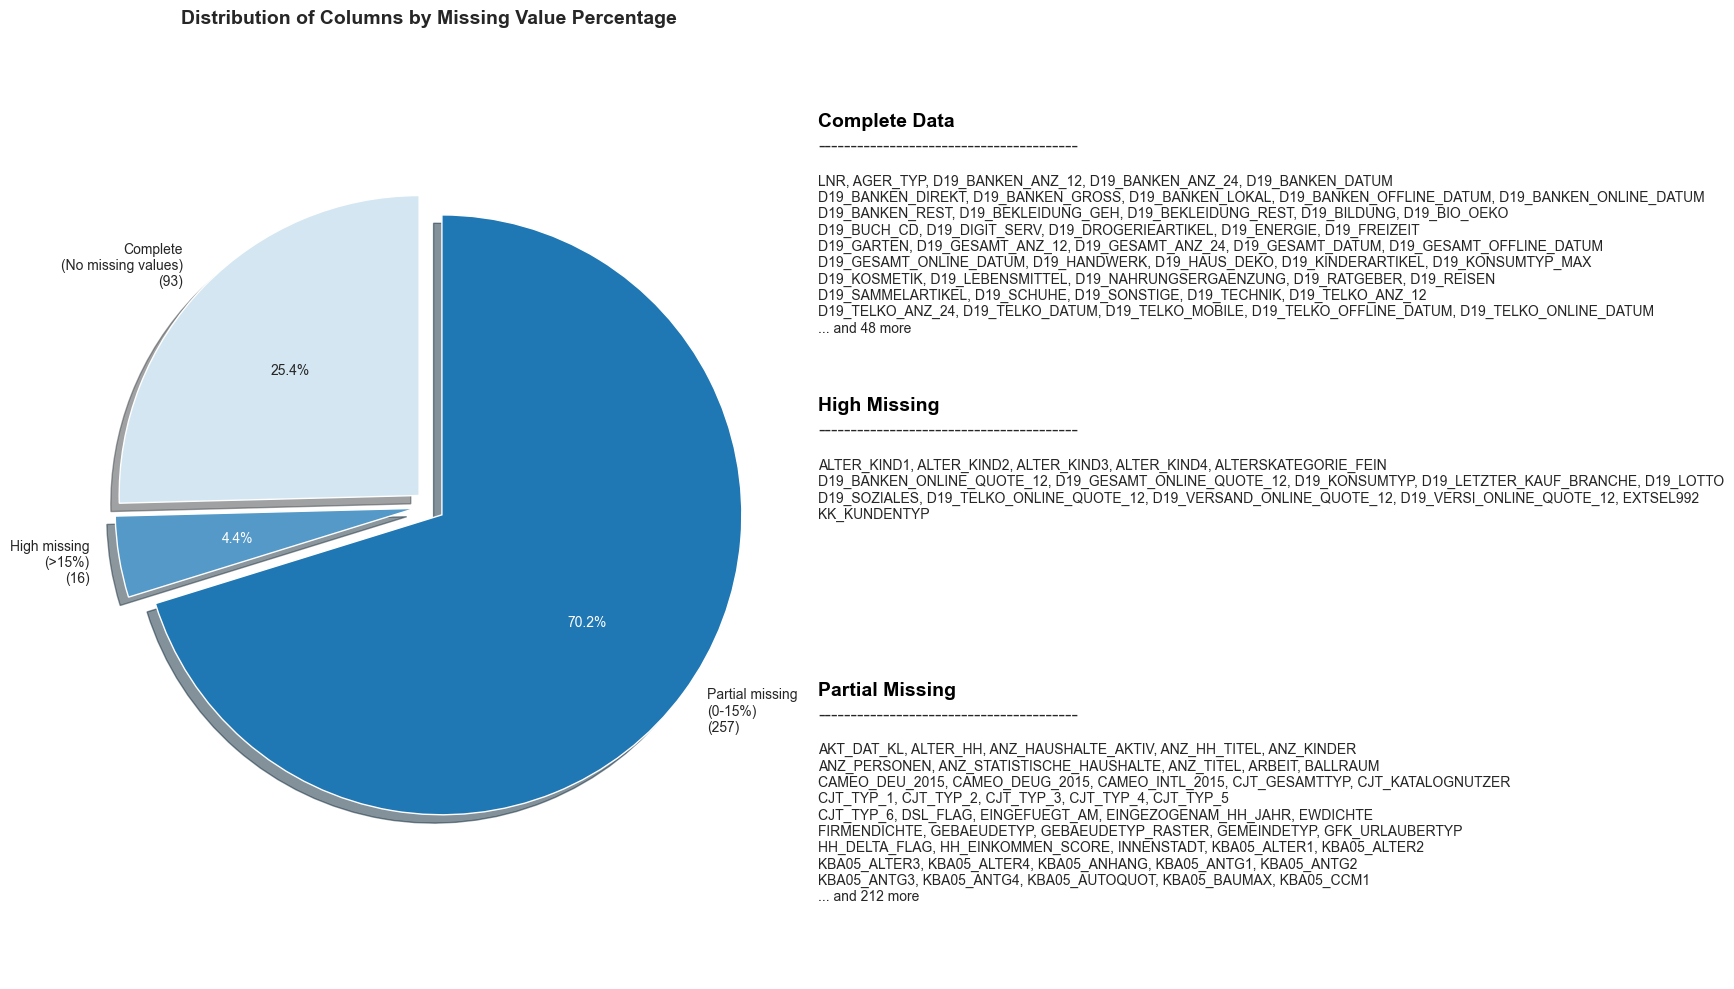

In [995]:
missing_categories = plot_missing_value_categories(azdias_data)

complete_columns = missing_categories['complete_data']
high_missing_columns = missing_categories['high_missing']
partial_missing_columns = missing_categories['partial_missing']

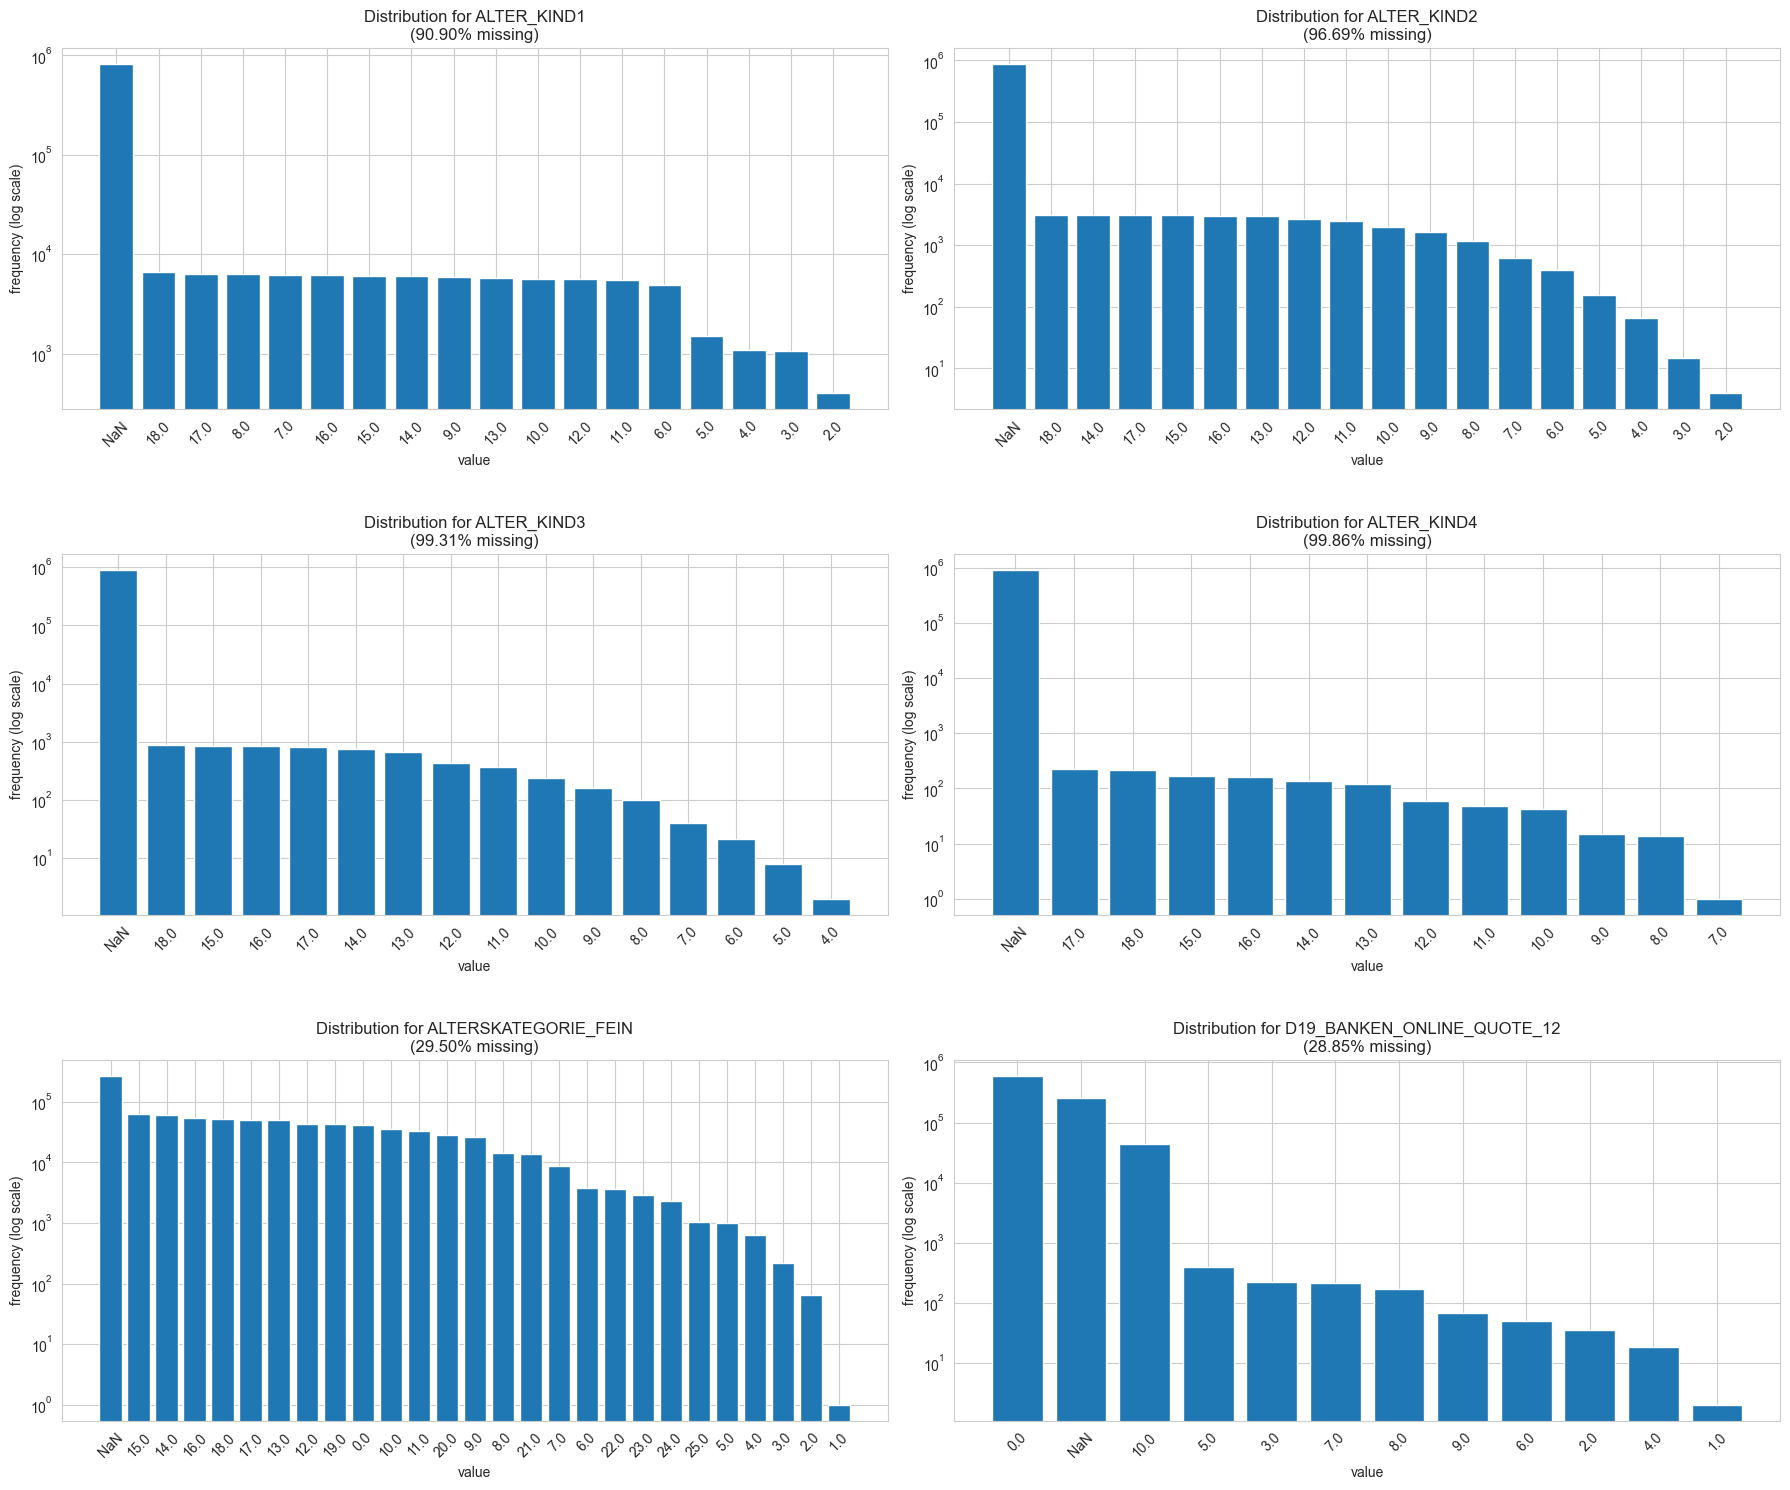

In [996]:
top_n = 6
column_categories = categorize_columns_by_missing_values(azdias_data, verbose=False)
high_missing_columns = column_categories['high_missing']
missing_stats = plot_value_distributions(azdias_data, high_missing_columns[:top_n])

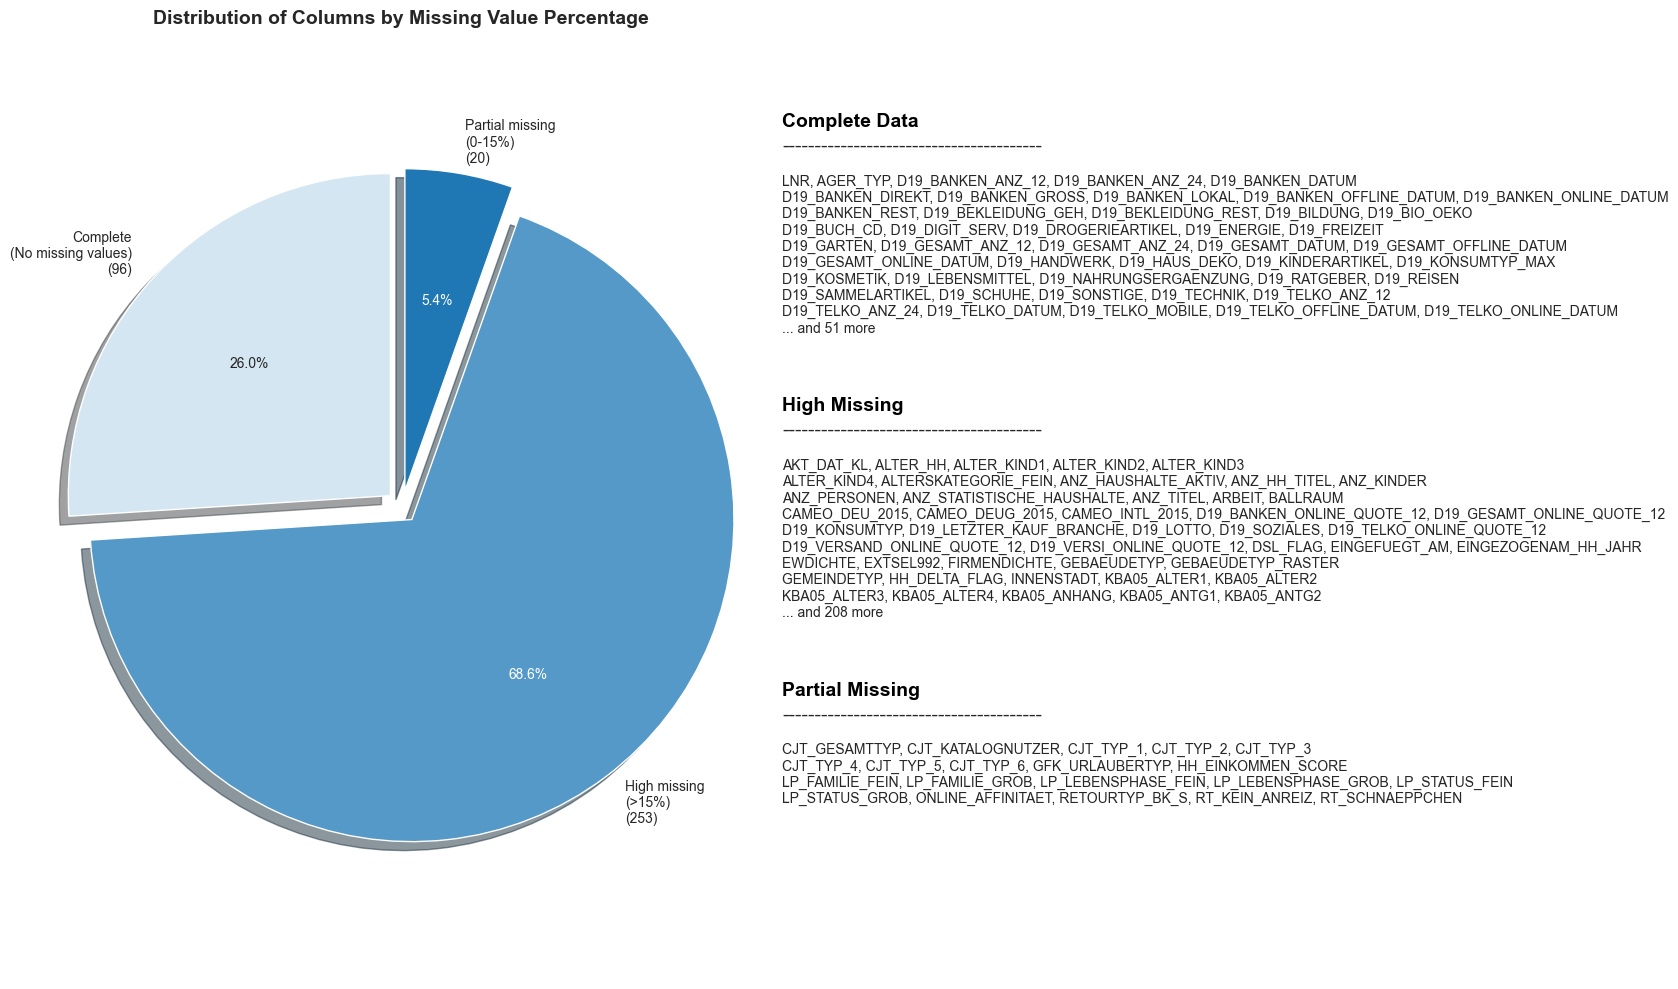

In [997]:
missing_categories_customers = plot_missing_value_categories(customers_data)

complete_columns_customers = missing_categories_customers['complete_data']
high_missing_columns_customers = missing_categories_customers['high_missing']
partial_missing_columns_customers = missing_categories_customers['partial_missing']

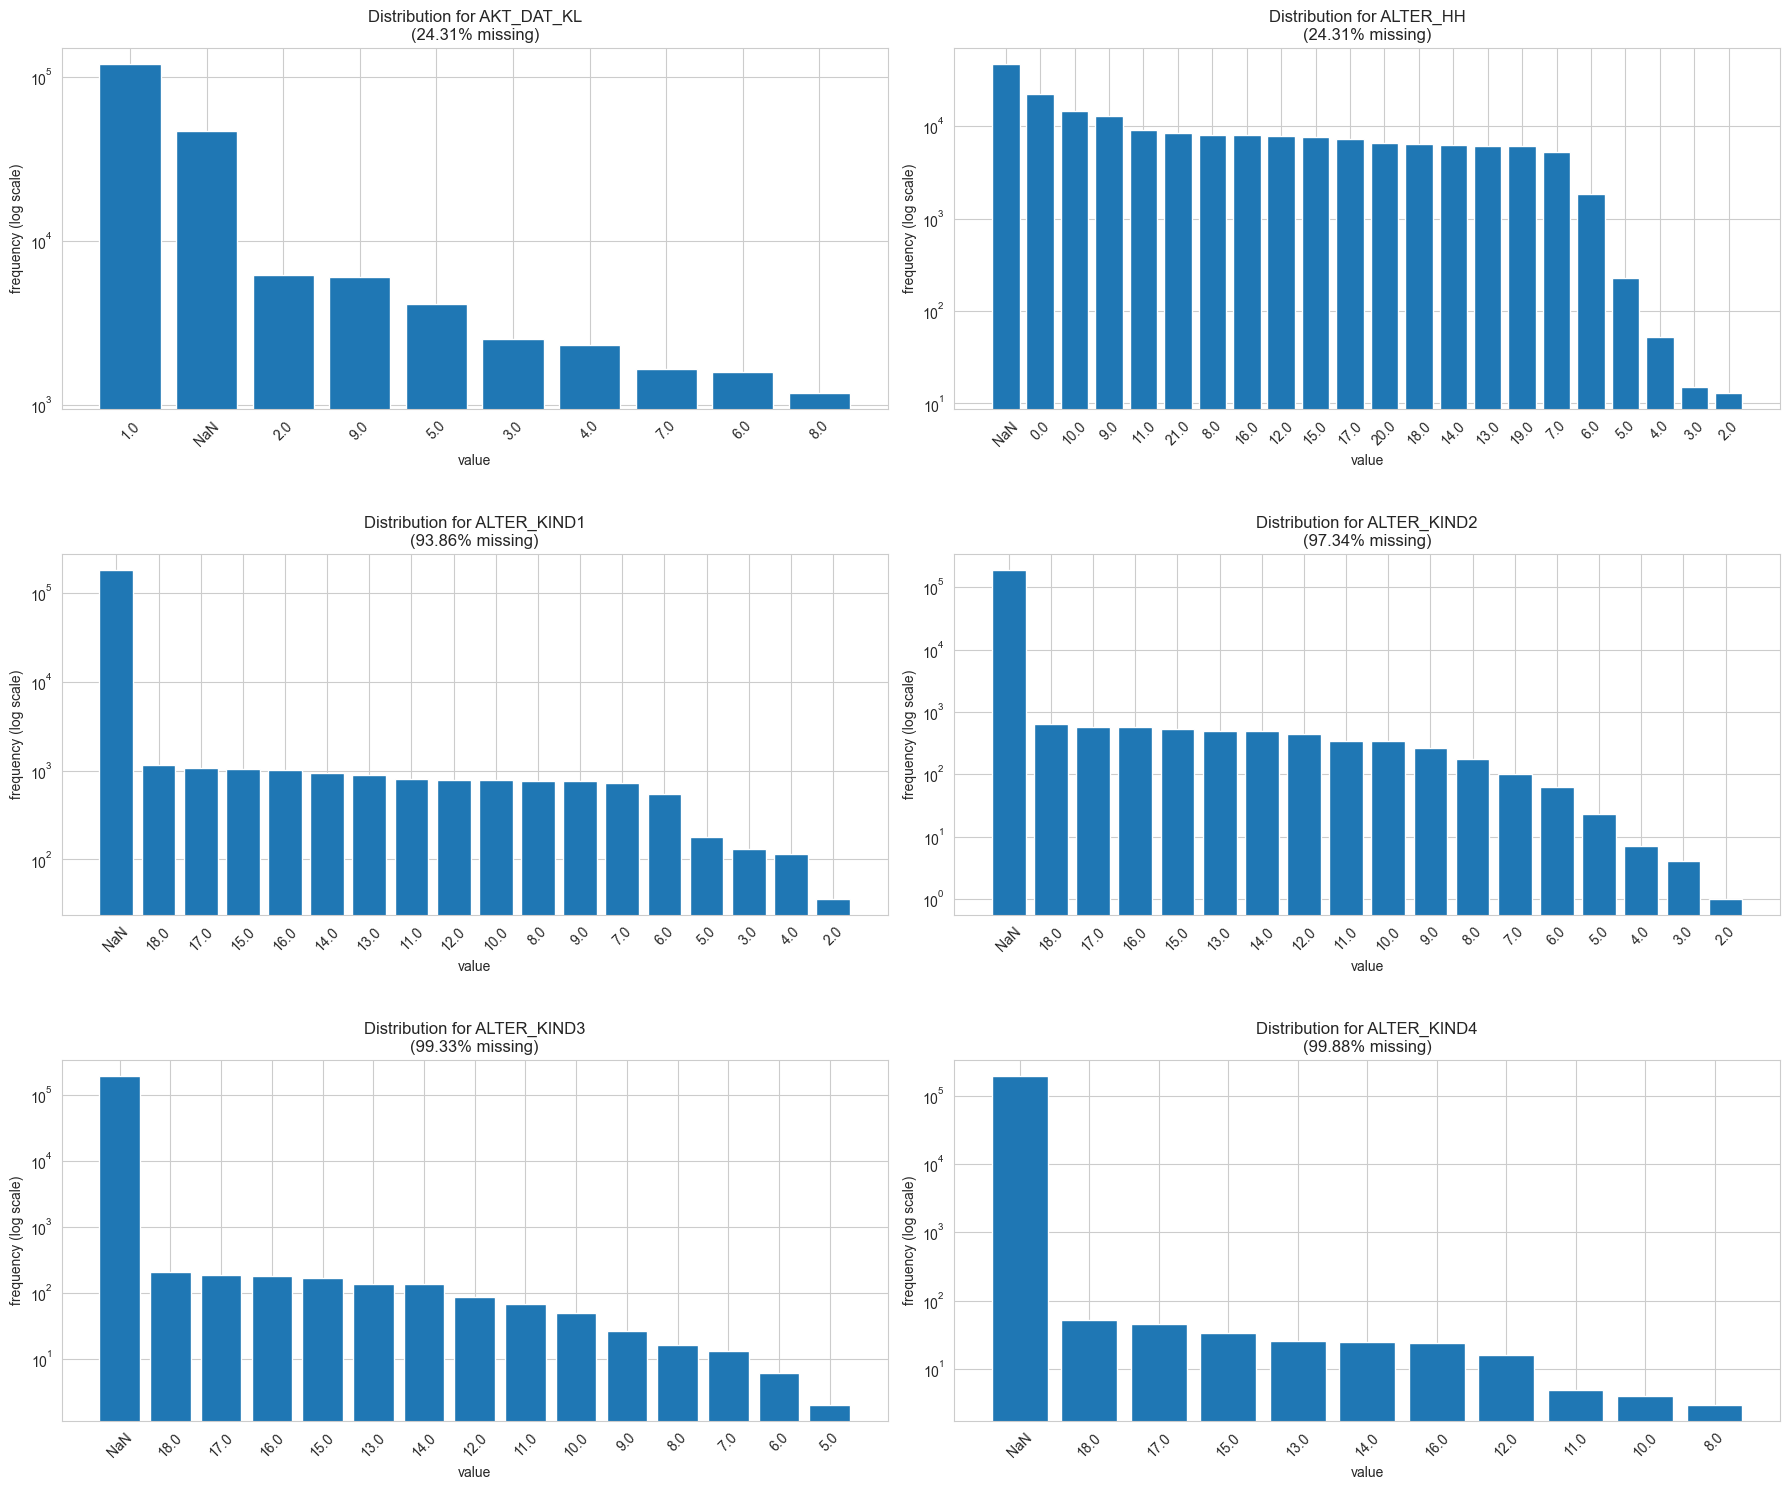

In [998]:
top_n = 6
column_categories_customers = categorize_columns_by_missing_values(customers_data, verbose=False)
high_missing_columns_customers = column_categories_customers['high_missing']
missing_stats_customers = plot_value_distributions(customers_data, high_missing_columns_customers[:top_n])

In [999]:
sample_size = 50000
[azdias_cleaned_data, customers_cleaned_data, mailout_train_cleaned_data, mailout_test_cleaned_data], stats = clean_dataframe([azdias_data[:sample_size], customers_data[:sample_size], mailout_train[:sample_size], mailout_test[:sample_size]],columns=True,rows=False)


azdias_cleaned_data, stats = clean_dataframe(azdias_cleaned_data,columns=False,rows=True)
customers_cleaned_data, stats= clean_dataframe(customers_cleaned_data,columns=False,rows=True)
mailout_train_cleaned_data, stats = clean_dataframe(mailout_train_cleaned_data,columns=False,rows=True)
mailout_test_cleaned_data, stats = clean_dataframe(mailout_test_cleaned_data,columns=False,rows=True)




Cleaning Summary:
  Original dataframe shape: 50000 rows x 366 columns
  Columns removed: 263 (71.86%)
  Rows removed: 0 (0.00%)
  Final dataframe shape: 50000 rows x 103 columns
  Data volume retained: 28.14%

Cleaning Summary:
  Original dataframe shape: 50000 rows x 369 columns
  Columns removed: 263 (71.27%)
  Rows removed: 0 (0.00%)
  Final dataframe shape: 50000 rows x 106 columns
  Data volume retained: 28.73%

Cleaning Summary:
  Original dataframe shape: 42962 rows x 367 columns
  Columns removed: 263 (71.66%)
  Rows removed: 0 (0.00%)
  Final dataframe shape: 42962 rows x 104 columns
  Data volume retained: 28.34%

Cleaning Summary:
  Original dataframe shape: 42833 rows x 366 columns
  Columns removed: 263 (71.86%)
  Rows removed: 0 (0.00%)
  Final dataframe shape: 42833 rows x 103 columns
  Data volume retained: 28.14%

Cleaning Summary:
  Original dataframe shape: 50000 rows x 103 columns
  Columns removed: 0 (0.00%)
  Rows removed: 38410 (76.82%)
  Final dataframe shape:

In [1000]:
azdias_cleaned_data

LNR  CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  \
1      910220            5.0                1.0        5.0        5.0   
2      910225            3.0                2.0        4.0        4.0   
3      910226            2.0                3.0        2.0        2.0   
4      910241            5.0                3.0        3.0        3.0   
5      910244            2.0                5.0        2.0        1.0   
...       ...            ...                ...        ...        ...   
49987  589768            6.0                5.0        2.0        2.0   
49991  890770            3.0                3.0        3.0        2.0   
49995  780964            6.0                1.0        5.0        5.0   
49996  780966            2.0                5.0        2.0        1.0   
49997  780972            3.0                1.0        5.0        5.0   

       CJT_TYP_3  CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  ...  \
1            2.0        3.0        1.0        1.0                  0  ...   
2            1.0        3.0        2.0        2.0                  0  ...   
3            4.0        4.0        5.0        3.0                  0  ...   
4            3.0        4.0        3.0        3.0                  3  ...   
5            5.0        5.0        3.0        3.0                  0  ...   
...          ...        ...        ...        ...                ...  ...   
49987        5.0        5.0        5.0        5.0                  0  ...   
49991        4.0        4.0        4.0        2.0                  0  ...   
49995        1.0        1.0        1.0        2.0                  0  ...   
49996        5.0        5.0        5.0        5.0                  0  ...   
49997        2.0        2.0        3.0        2.0                  0  ...   

       SEMIO_MAT  SEMIO_PFLICHT  SEMIO_RAT  SEMIO_REL  SEMIO_SOZ  SEMIO_TRADV  \
1              3              7          6          4          5            6   
2              3              3          4          3          4            3   
3              1              4          3          2          5            4   
4              2              4          2          4          6            2   
5              4              7          7          7          2            6   
...          ...            ...        ...        ...        ...          ...   
49987          4              4          1          5          3            4   
49991          4              4          4          4          6            4   
49995          3              5          6          4          2            7   
49996          1              2          2          1          4            3   
49997          3              5          4          7          7            5   

       SEMIO_VERT  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB  
1               1         5          2                   1.0  
2               4         5          2                   3.0  
3               4         3          2                   4.0  
4               7         4          1                   3.0  
5               2         4          2                   1.0  
...           ...       ...        ...                   ...  
49987           6         3          1                   4.0  
49991           5         1          1                   3.0  
49995           4         5          2                   2.0  
49996           3         3          2                   4.0  
49997           6         4          1                   1.0  

[11590 rows x 103 columns]

In [1001]:
customers_cleaned_data

LNR  CJT_GESAMTTYP  CJT_KATALOGNUTZER  CJT_TYP_1  CJT_TYP_2  \
6      143904            2.0                5.0        1.0        1.0   
8      102160            1.0                5.0        2.0        2.0   
11     102185            3.0                3.0        1.0        1.0   
12     102227            5.0                4.0        2.0        1.0   
13     102230            6.0                4.0        3.0        3.0   
...       ...            ...                ...        ...        ...   
49986   23391            3.0                1.0        2.0        2.0   
49987   23406            6.0                2.0        3.0        2.0   
49988   23416            2.0                4.0        1.0        1.0   
49993   23451            2.0                2.0        2.0        2.0   
49998  115940            2.0                5.0        2.0        2.0   

       CJT_TYP_3  CJT_TYP_4  CJT_TYP_5  CJT_TYP_6  D19_BANKEN_ANZ_12  ...  \
6            5.0        5.0        5.0        5.0                  0  ...   
8            5.0        5.0        5.0        5.0                  0  ...   
11           5.0        5.0        5.0        5.0                  0  ...   
12           4.0        4.0        5.0        5.0                  0  ...   
13           3.0        4.0        4.0        2.0                  0  ...   
...          ...        ...        ...        ...                ...  ...   
49986        3.0        3.0        5.0        2.0                  1  ...   
49987        3.0        4.0        3.0        2.0                  2  ...   
49988        5.0        5.0        5.0        5.0                  0  ...   
49993        5.0        4.0        4.0        4.0                  0  ...   
49998        5.0        5.0        5.0        5.0                  0  ...   

       SEMIO_REL  SEMIO_SOZ  SEMIO_TRADV  SEMIO_VERT  ZABEOTYP  \
6              5          4            4           6         1   
8              1          2            1           2         3   
11             5          6            4           7         1   
12             3          6            1           6         1   
13             4          3            2           7         4   
...          ...        ...          ...         ...       ...   
49986          4          3            4           7         1   
49987          4          3            4           5         1   
49988          3          6            4           6         1   
49993          4          6            2           5         1   
49998          2          5            1           4         3   

           PRODUCT_GROUP  CUSTOMER_GROUP  ONLINE_PURCHASE  ANREDE_KZ  \
6      COSMETIC_AND_FOOD     MULTI_BUYER                0          1   
8               COSMETIC     MULTI_BUYER                0          2   
11                  FOOD    SINGLE_BUYER                0          1   
12                  FOOD    SINGLE_BUYER                0          1   
13                  FOOD    SINGLE_BUYER                1          1   
...                  ...             ...              ...        ...   
49986  COSMETIC_AND_FOOD     MULTI_BUYER                0          1   
49987  COSMETIC_AND_FOOD     MULTI_BUYER                0          1   
49988           COSMETIC    SINGLE_BUYER                0          1   
49993  COSMETIC_AND_FOOD     MULTI_BUYER                0          1   
49998  COSMETIC_AND_FOOD     MULTI_BUYER                0          2   

       ALTERSKATEGORIE_GROB  
6                       4.0  
8                       4.0  
11                      4.0  
12                      4.0  
13                      3.0  
...                     ...  
49986                   3.0  
49987                   3.0  
49988                   4.0  
49993                   3.0  
49998                   4.0  

[10552 rows x 106 columns]

In [1002]:
# Get statistics for the after cleaning dataframe
azdias_cleaned_data_stats = get_dataframe_stats(azdias_cleaned_data)


DataFrame Statistics:
    General Summary:
    Dimensions: 11,590 rows × 103 columns
    Memory usage: 9.20 MB
    Rows with missing values: 0 (0.00%)


    Data Type Distribution:
    int64: 69 columns (67.0%)
    float64: 34 columns (33.0%)


    Total number of rows: 11,590
    Total number of columns: 103
    Percentage of rows with missing data: 0.00%




In [1003]:
# Get statistics for the after cleaning dataframe
customers_cleaned_data_stats = get_dataframe_stats(customers_cleaned_data)

DataFrame Statistics:
    General Summary:
    Dimensions: 10,552 rows × 106 columns
    Memory usage: 9.83 MB
    Rows with missing values: 0 (0.00%)


    Data Type Distribution:
    int64: 70 columns (66.0%)
    float64: 34 columns (32.1%)
    object: 2 columns (1.9%)


    Total number of rows: 10,552
    Total number of columns: 106
    Percentage of rows with missing data: 0.00%




# Data Visualizations & Analysis

In [1008]:
def create_grid_plots(data, columns, 
                      plot_type, 
                      category_name, 
                      ncols=2, 
                      plot_title_prefix='General Population'):
    
    """
    Create a grid of plots (histograms for numeric data and
    bar plots for categorical data) for columns in a given DataFrame.

    Parameters
    ----------
    data : pandas.DataFrame
        The input DataFrame containing the data to visualize.
    columns : list of str
        List of column names from the DataFrame to plot.
    plot_type : str
        Type of plot to generate. 
        Accepts 'histogram' for numeric variables or 'categorical'
        for categorical variables.
    category_name : str
        A descriptive label for the category of plots,
        used in the overall title of the figure.
    ncols : int, optional
        Number of columns in the grid layout of subplots. Default is 2.
    plot_title_prefix : str, optional
        Prefix used in the title of the entire figure. 
        Default is 'General Population'.

    Returns
    -------
    None
        The function displays the plots and does not return any value.

    Notes
    -----
    - For numeric data, histograms are plotted with 
      overlaid mean and median lines.
    - For categorical data, top categories are shown (up to 12), 
      and smaller ones are grouped as 'Other'.
    - Subplots are dynamically arranged based on the number of columns 
    and specified ncols.
    - Any unused subplot axes are hidden.
    """
    
    if not columns:
        return
    max_unique_vals = 12
    nrows = math.ceil(len(columns) / ncols)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))

    # Convert to 2D array if needed
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    if nrows == 1 or ncols == 1:
        axes = axes.reshape(-1, 1) if ncols == 1 else axes.reshape(1, -1)
    
    for i, col in enumerate(columns):
        row_idx = i // ncols
        col_idx = i % ncols
        
        if plot_type == 'histogram':
            # Create histogram for numeric variables
            sns.histplot(data[col].dropna(), 
                         kde=False, bins=20, 
                         ax=axes[row_idx, col_idx])
            
            axes[row_idx, col_idx].axvline(
                data[col].median(), color='red', linestyle='--', 
                label=f'Median: {data[col].median():.2f}')
            
            axes[row_idx, col_idx].axvline(
                data[col].mean(), color='green', linestyle='--', 
                label=f'Mean: {data[col].mean():.2f}')
            
            axes[row_idx, col_idx].legend(fontsize=8)
            
        elif plot_type == 'categorical':
            
            # Get value counts and calculate percentages
            val_counts = data[col].value_counts().sort_values(ascending=False)
            
            # Limit to top categories if there are too many
            if len(val_counts) > max_unique_vals:                
                other_count = val_counts.iloc[max_unique_vals:].sum()
                val_counts = val_counts.iloc[:max_unique_vals]
                val_counts['Other'] = other_count
                
            val_pcts = val_counts / val_counts.sum() * 100
            
            # Plot
            sns.barplot(x=val_pcts.index, 
                        y=val_pcts.values, 
                        ax=axes[row_idx, col_idx])
            
            axes[row_idx, col_idx].set_title(f'{col}')
            axes[row_idx, col_idx].set_xlabel('')
            axes[row_idx, col_idx].set_ylabel('Percentage (%)')
            axes[row_idx, col_idx].tick_params(axis='x', rotation=45)
            
            # Add percentage labels on bars
            for p in axes[row_idx, col_idx].patches:
                if p.get_height() > 1:  
                    axes[row_idx, col_idx].annotate(
                        f'{p.get_height():.1f}%', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=8)
        
    
    # Hide any unused subplots
    for i in range(len(columns), nrows * ncols):
        row_idx = i // ncols
        col_idx = i % ncols
        axes[row_idx, col_idx].set_visible(False)
        
    fig.suptitle(f'{plot_title_prefix}: {category_name}\n\n', 
                 fontsize=16, x=0.2)

    plt.tight_layout()
    plt.subplots_adjust(top=0.865)
    plt.show()
    
    return


def visualize_population_demographics(
    data,plot_title_prefix='General Population'):
    """
    Create comprehensive demographic visualizations for population data.
    
    Parameters
    ----------
    data : pandas.DataFrame
        DataFrame containing demographic data
    plot_title_prefix : str, optional
        Prefix to add to all plot titles, by default 'General Population'
        
    Note
    ----
    Plots are arranged in grid
    """
    # Set visualization style
    sns.set_style("whitegrid")
    
    # 1. Income-related columns
    income_cols = [
        col for col in data.columns 
        if any(term in col.lower() for term in (
            'income', 'einkommen', 'verdienst', 'gehalt'))
        ]
        
    if income_cols:
        create_grid_plots(data, income_cols, 
                          'histogram', 
                          'Income Distribution',
                          plot_title_prefix=plot_title_prefix)
     
    # 2. Household/Family Composition
    household_cols = [
        col for col in data.columns 
        if any(term in col.lower() for term in (
            'house', 'haus', 'famil', 'kind', 'child', 'hh_', 'haushalt'
            ))
        ]
    
    # Separate numeric and categorical household columns
    household_numeric = [col for col in household_cols 
                       if pd.api.types.is_numeric_dtype(data[col])]
    household_categorical = [col for col in household_cols 
                           if col not in household_numeric]
    
    if household_numeric:
        create_grid_plots(data, household_numeric, 'histogram', 
                          'Household Metrics (Numeric)',
                          plot_title_prefix=plot_title_prefix)
    
    if household_categorical:
        create_grid_plots(data, household_categorical, 
                          'categorical', 
                          'Household Metrics (Categorical)')
    
    # 3. Geographic distribution
    geo_categorical = [
        col for col in data.columns if any(term in col.lower() for term in (
            'region','stadt','city','land', 'state', 
            'geo', 'area', 'ort', 'plz'
            ))
        ]
   
    
    if geo_categorical:
        create_grid_plots(data, geo_categorical, 'categorical', 
                          'Geographic Distribution',
                          plot_title_prefix=plot_title_prefix)
    
    # 4. Education/Occupation
    edu_categorical = [
        col for col in data.columns 
        if any(term in col.lower() for term in (
            'edu', 'bild', 'school', 'schul', 'occupation', 
            'beruf', 'job', 'arbeit'))
        ]
    
    if edu_categorical:
        create_grid_plots(data, edu_categorical, 'categorical', 
                          'Education/Occupation',
                          plot_title_prefix=plot_title_prefix)
    
    # 5. Social class / lifestyle indicators
    social_categorical = [
        col for col in data.columns
        if any(term in col.lower() for term in (
            'social', 'sozial', 'class', 'klasse', 'status', 
            'life', 'leben', 'style', 'stil', 'wealth', 'reich'))
        ]
    
    if social_categorical:
        create_grid_plots(data, social_categorical, 'categorical', 
                          'Social Status/Lifestyle',
                          plot_title_prefix=plot_title_prefix)
    
    # 6. CAMEO socioeconomic classifications
    cameo_cols = [col for col in data.columns if 'cameo' in col.lower()]
    if cameo_cols:
        create_grid_plots(data, cameo_cols, 'categorical', 
                          'CAMEO Classifications',
                          plot_title_prefix=plot_title_prefix)

   
    # 7. Age & Gender
    age_cols = [col for col in data.columns 
                if any(term in col.lower() for term in (
                    'age', 'alter', 'jahr'))
                ]
    gender_cols = [col for col in data.columns 
                   if any(term in col.lower() for term in (
                       'gender', 'sex', 'geschlecht'))]
    
    if age_cols:
        create_grid_plots(data, age_cols[:4], 'histogram',
                          'Age Distribution',
                          plot_title_prefix=plot_title_prefix)
    
    if gender_cols:
        create_grid_plots(data, gender_cols, 'categorical',
                          'Gender Distribution',
                          plot_title_prefix=plot_title_prefix)


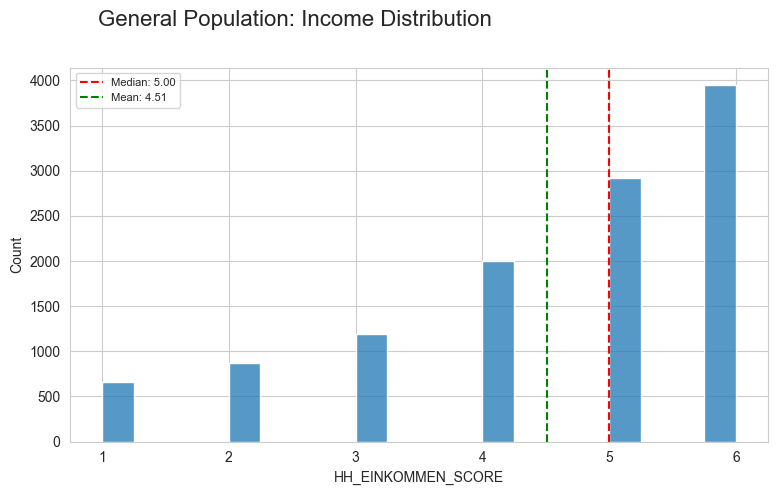

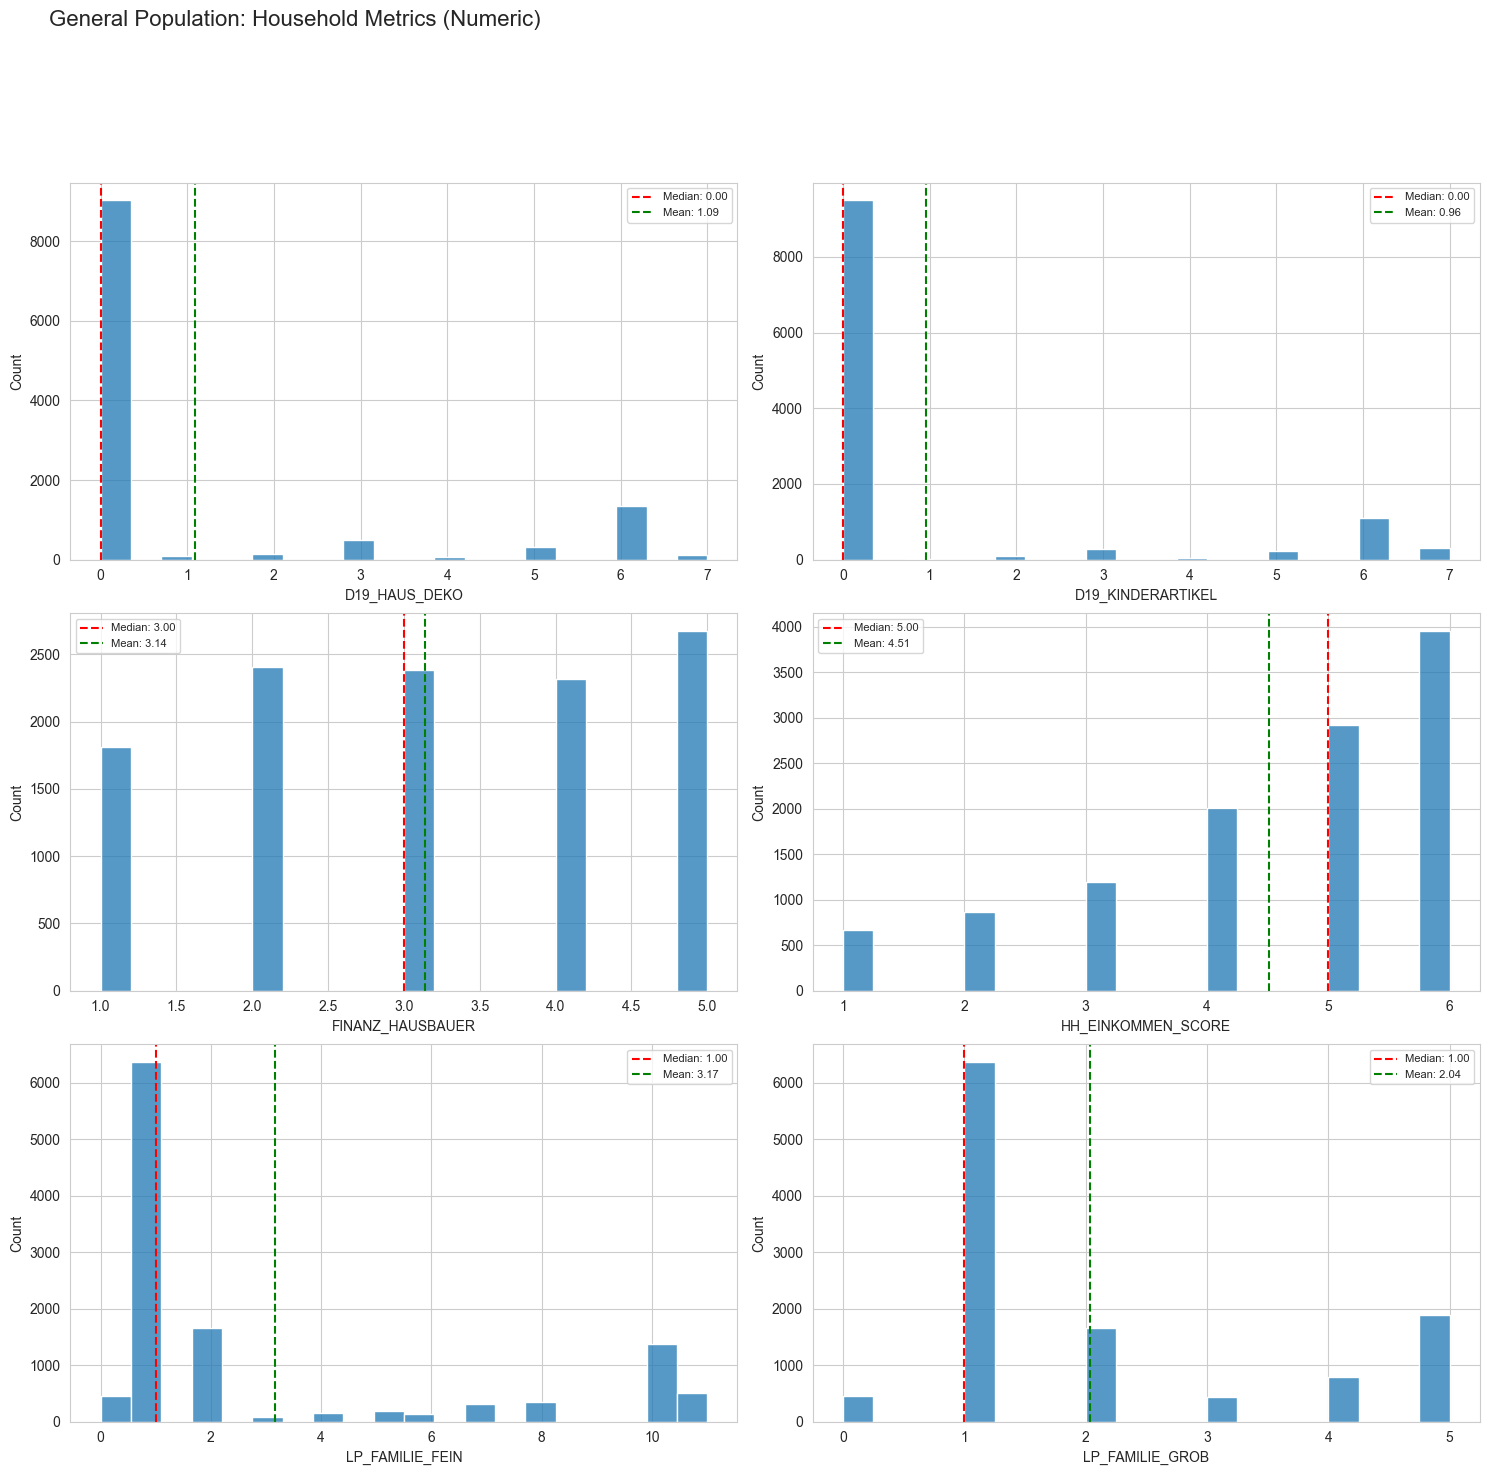

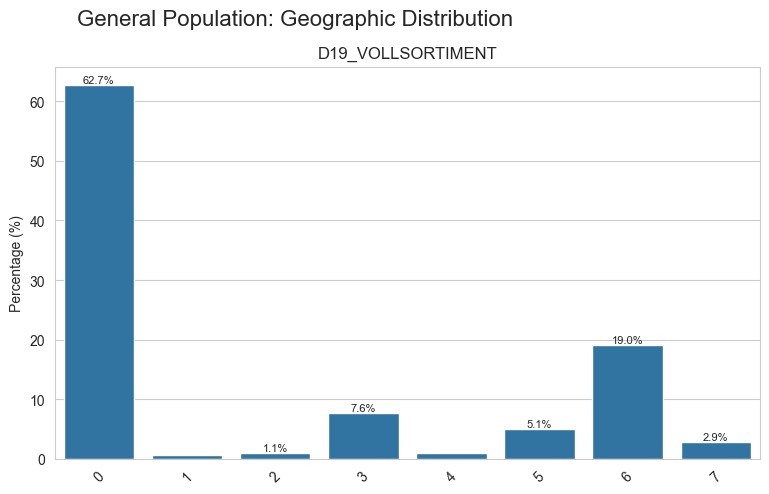

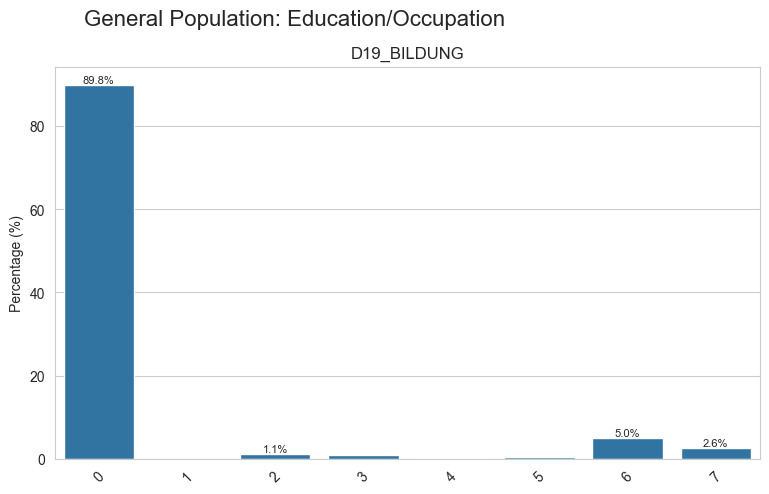

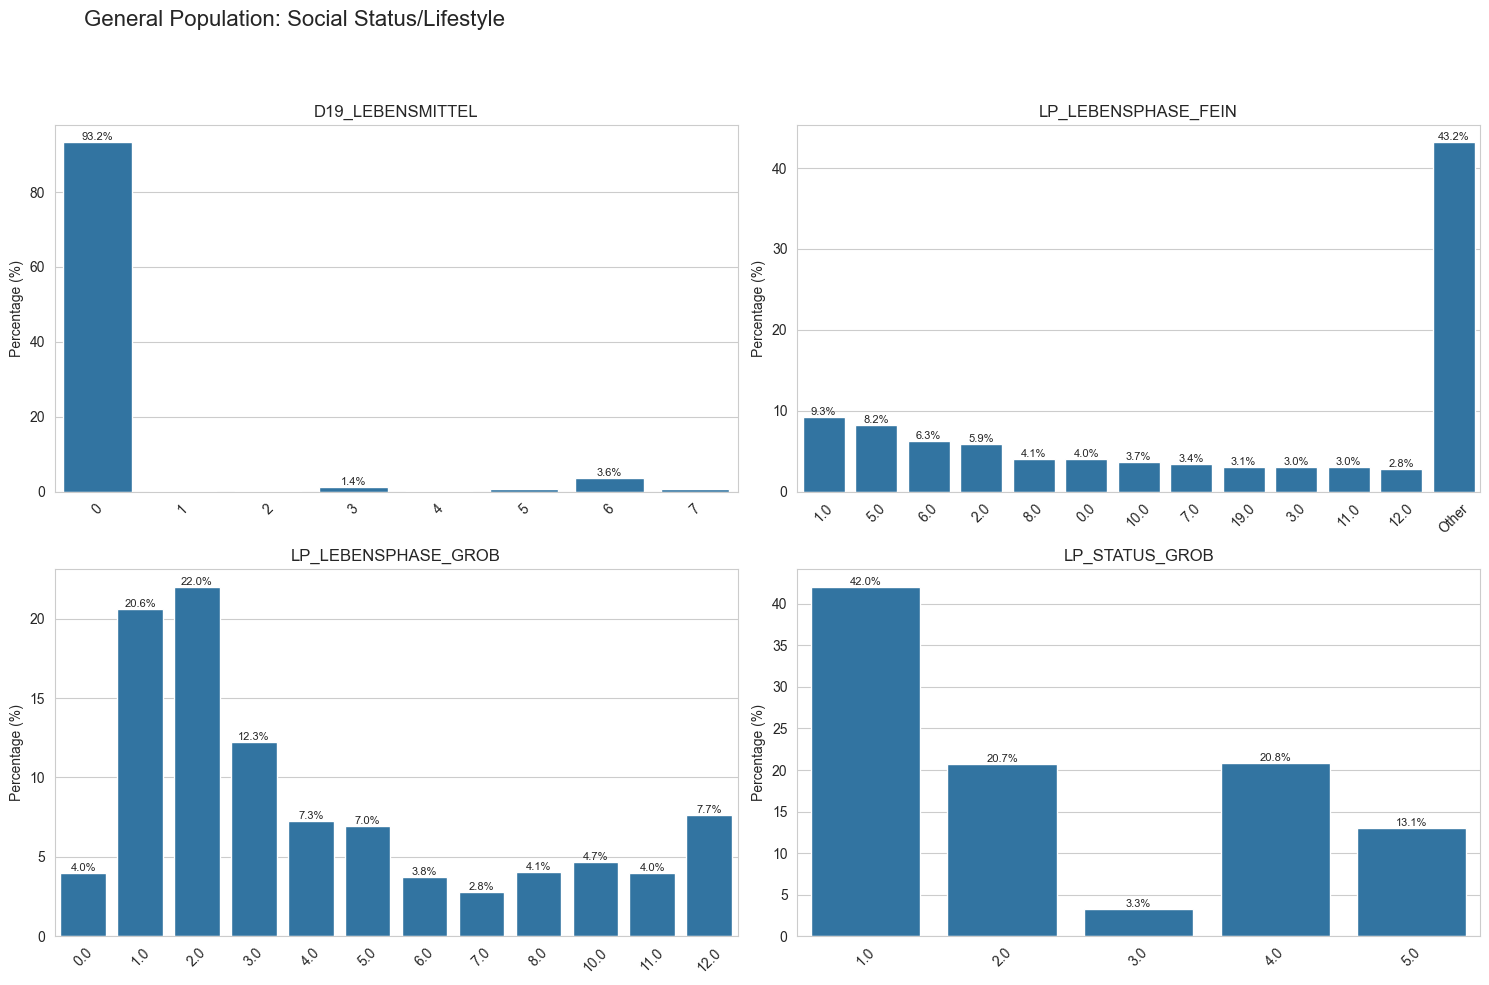

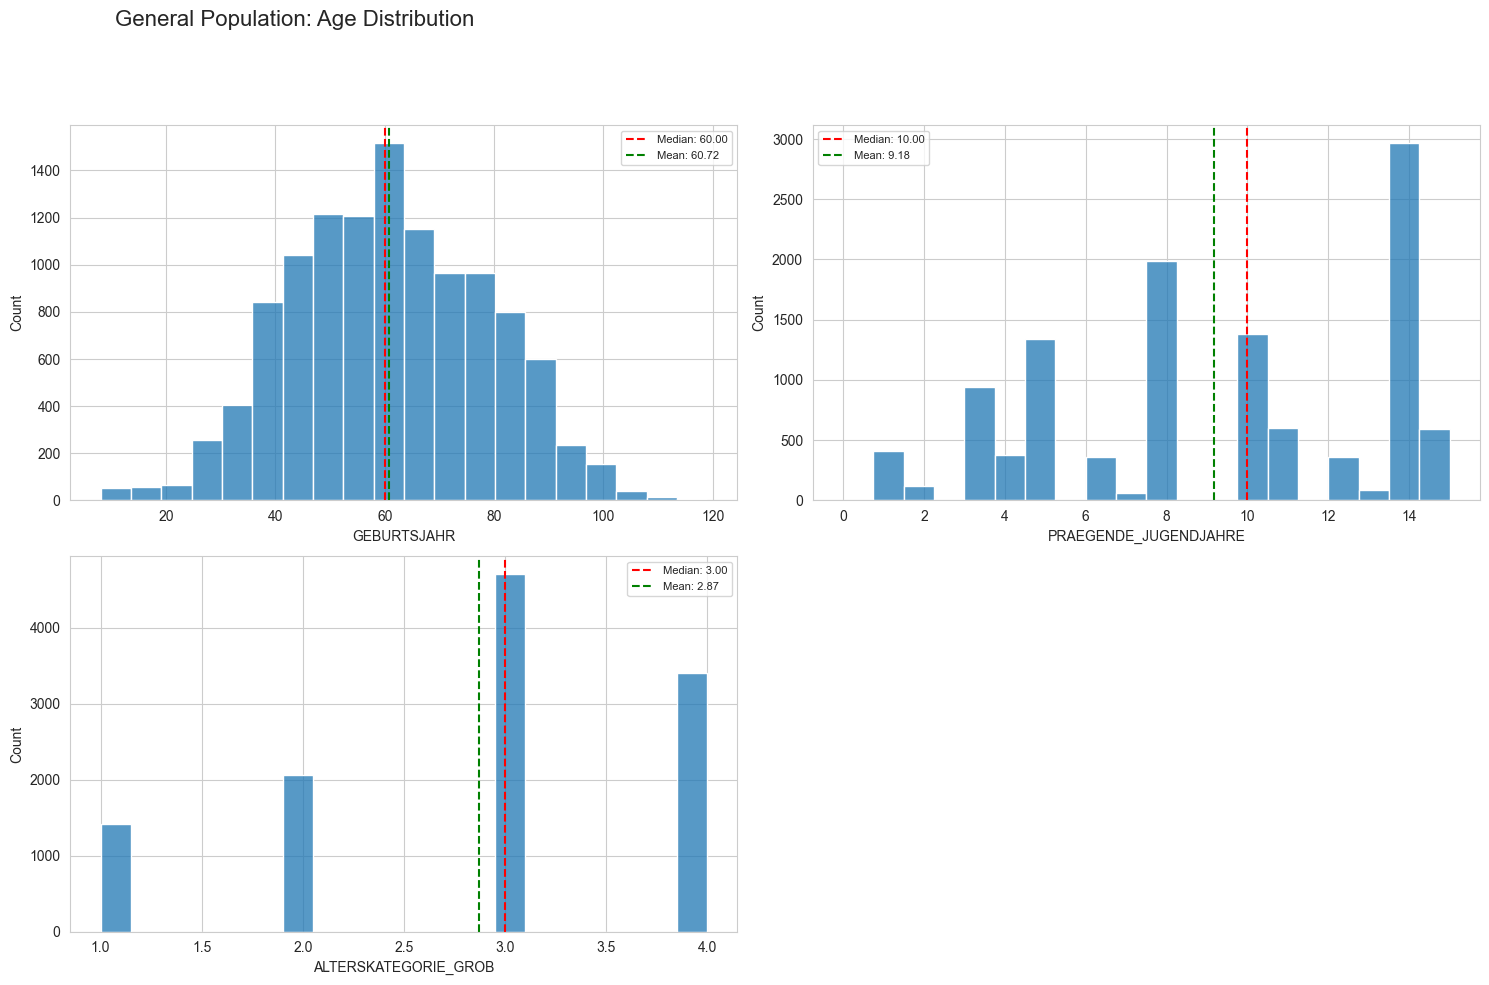

In [1009]:
visualize_population_demographics(azdias_cleaned_data, plot_title_prefix='General Population')

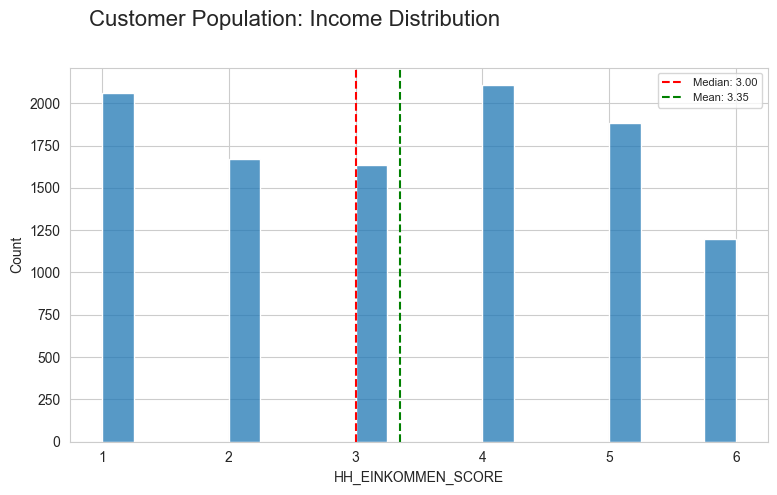

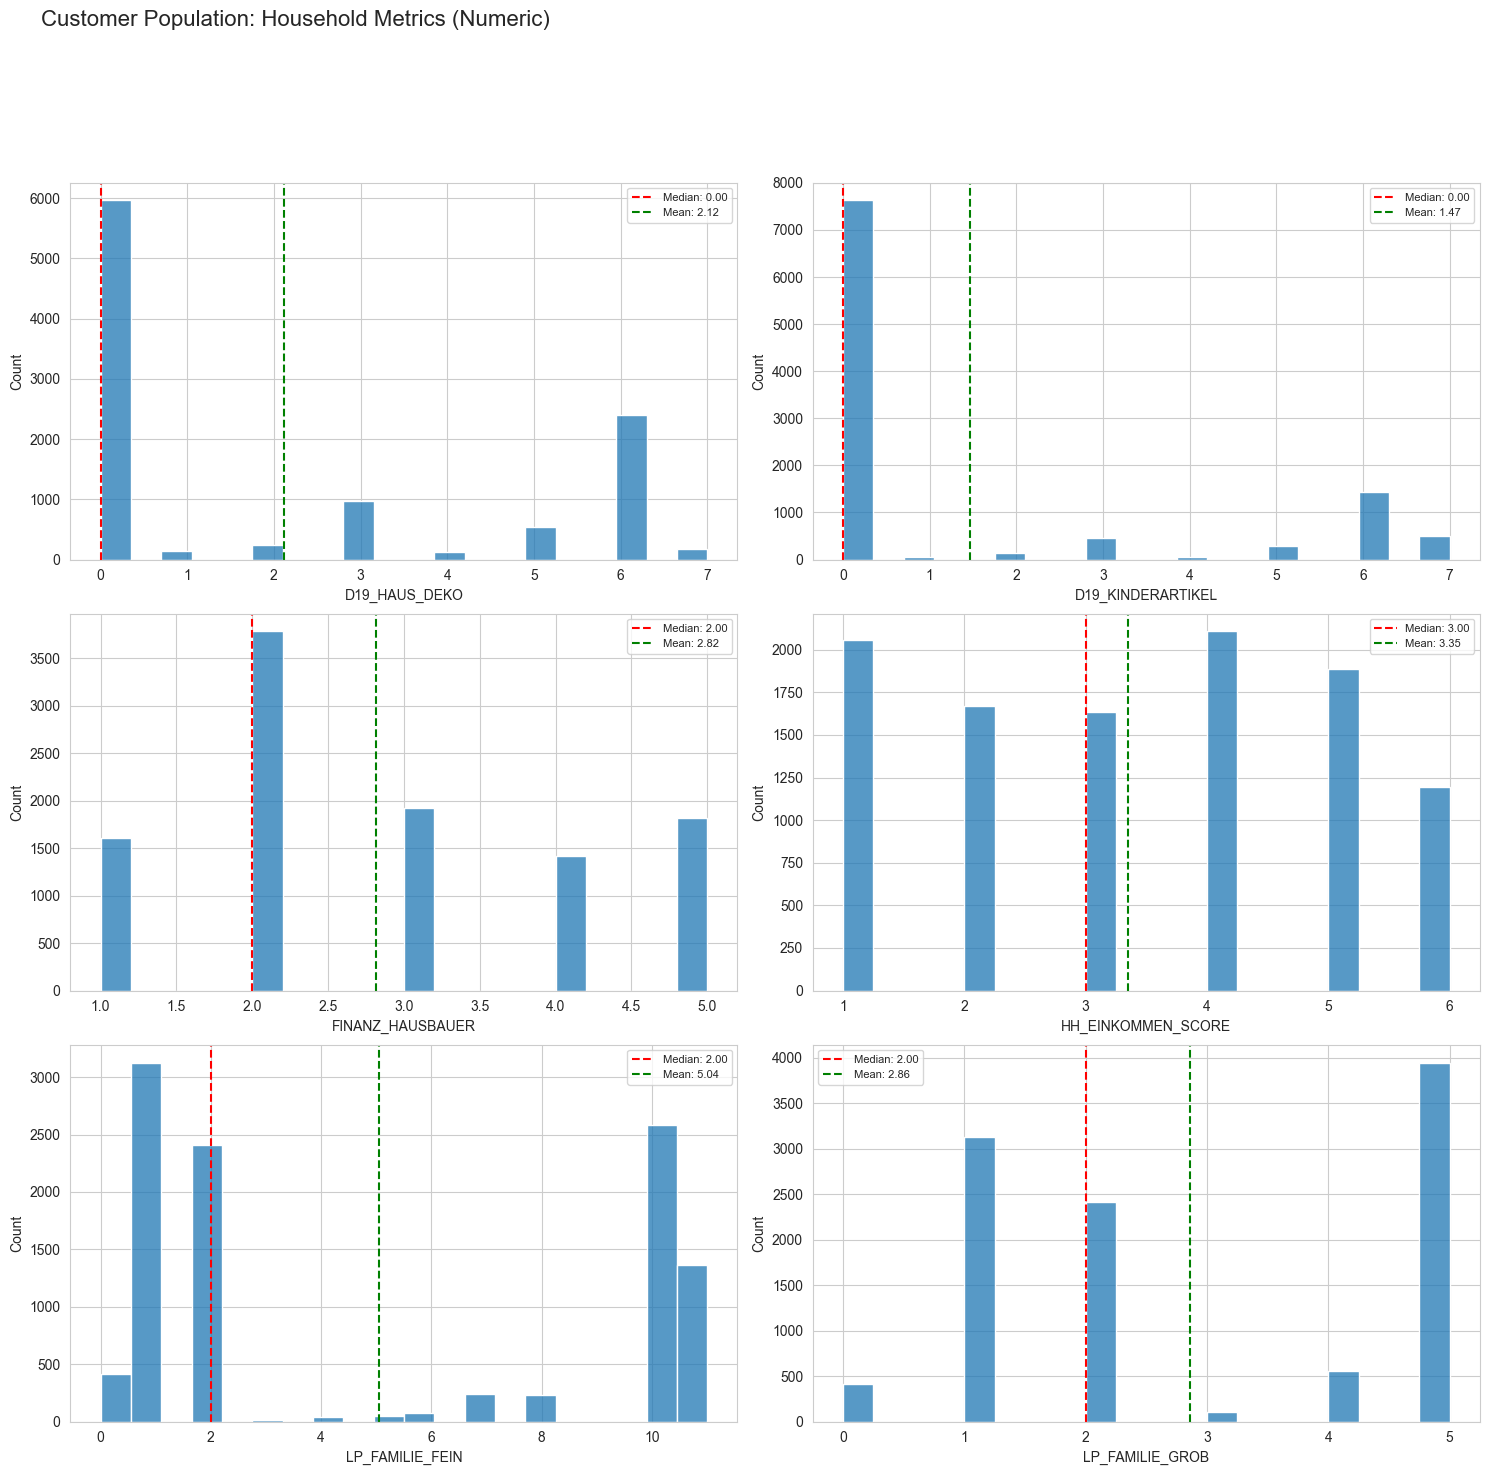

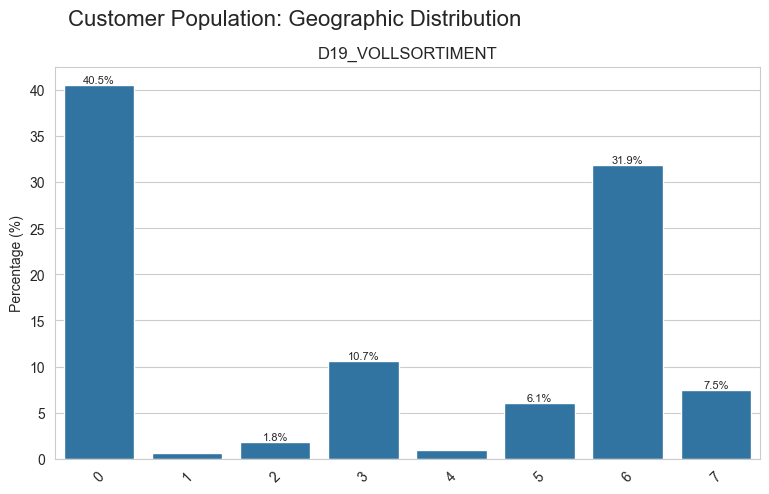

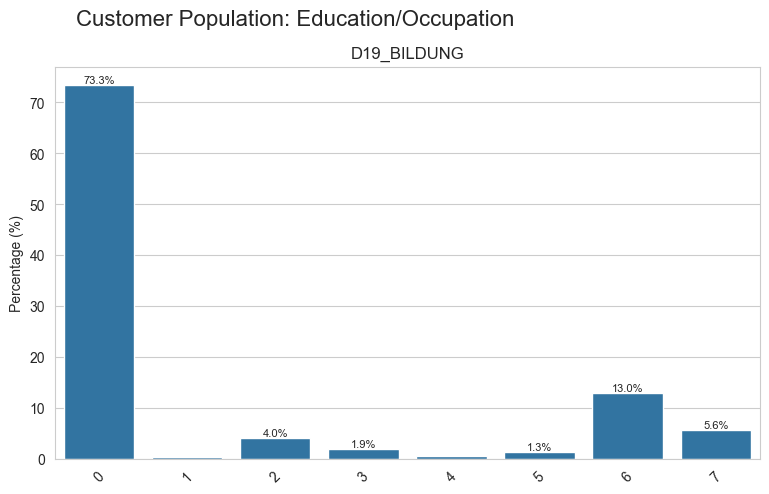

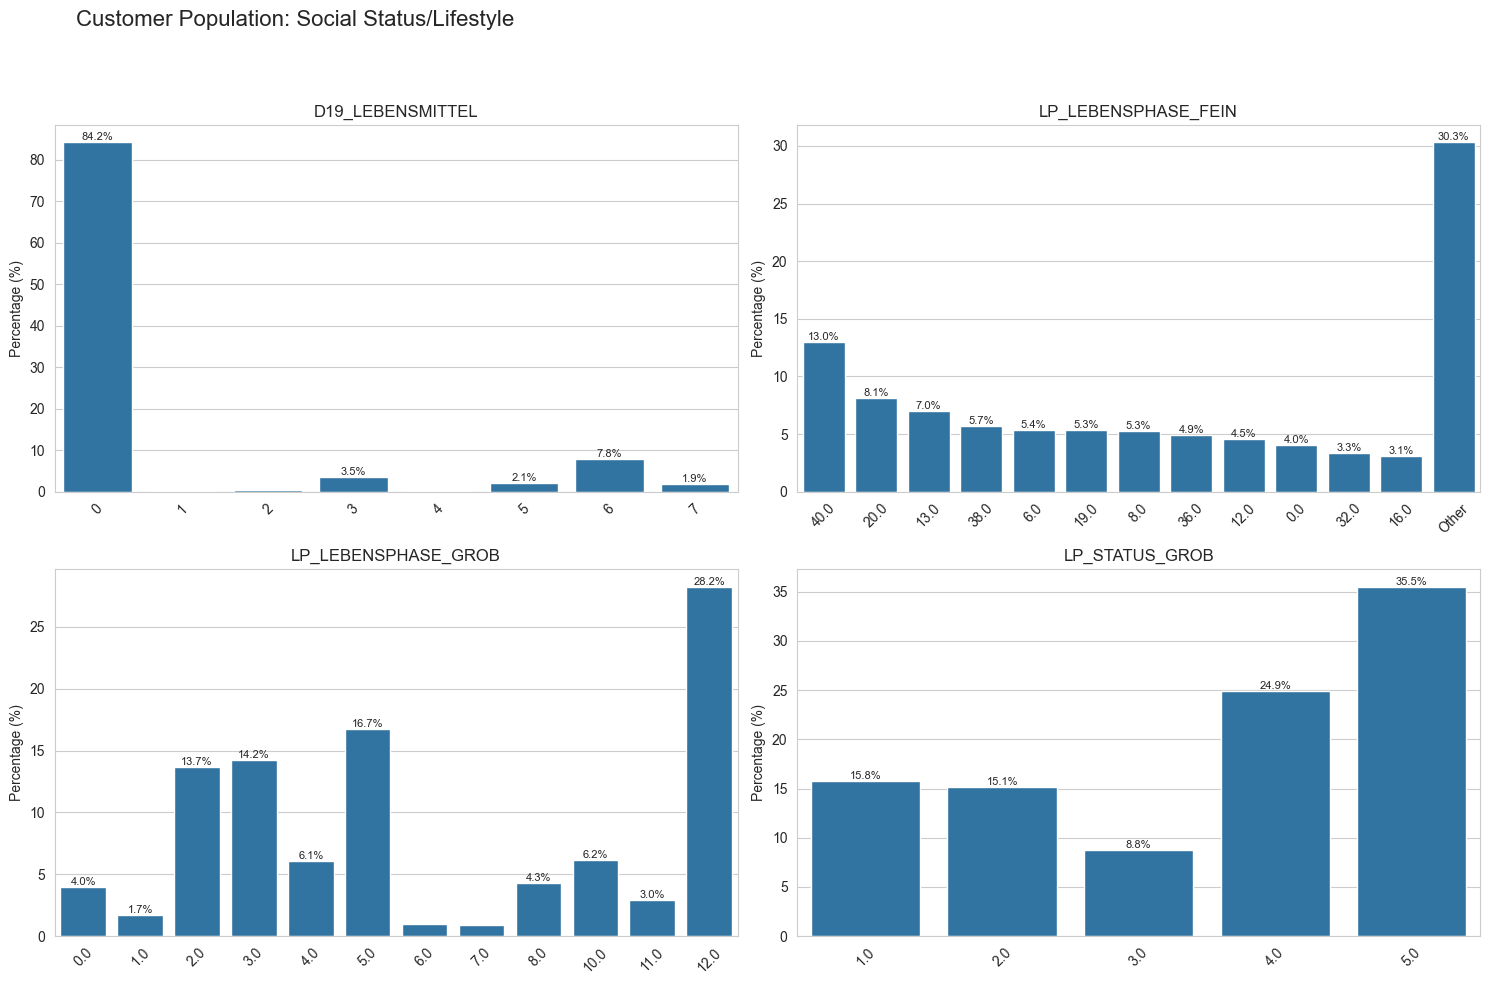

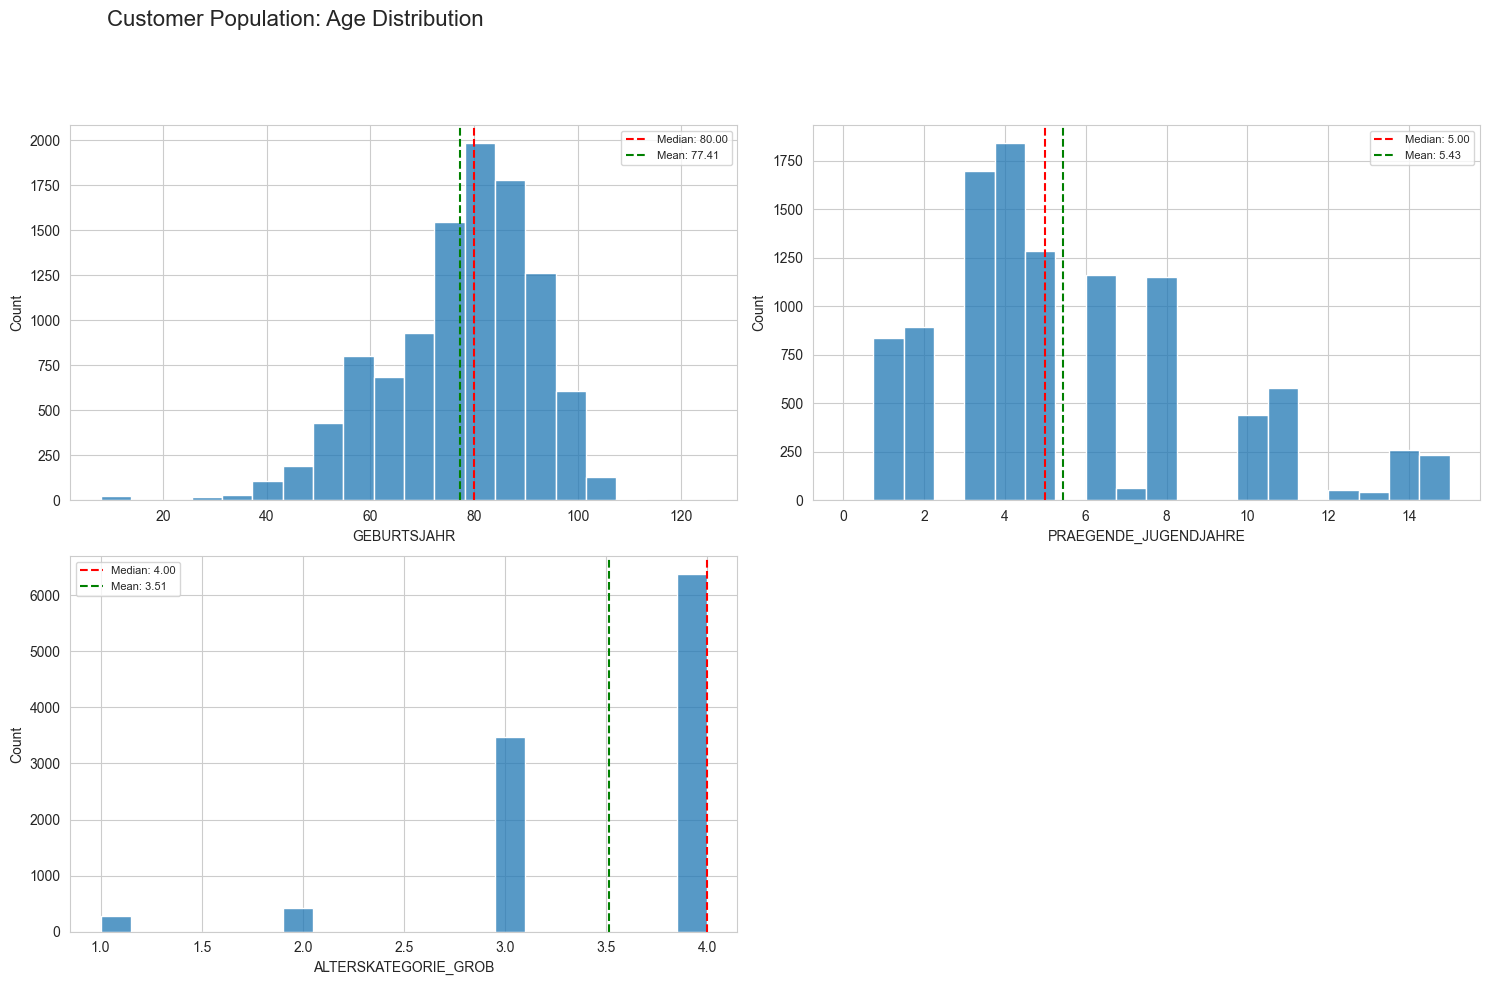

In [1010]:
visualize_population_demographics(customers_cleaned_data, plot_title_prefix='Customer Population')

# Data Transformation

In [1011]:
def transform_dataframe(dataframe, 
                        date_columns=None, 
                        numerical_columns=None, 
                        categorical_columns=None):
    """
    Transform dataframe(s) uniformly applying several transformations.
    
    Parameters
    ----------
    dataframe : pandas.DataFrame
        The dataframe to transform
    date_columns : list or None, optional
        List of columns to convert to datetime format, by default None
    categorical_columns : list or None, optional
        List of columns to convert to categorical data type, 
        default, None
    
    Returns
    -------
    pandas.DataFrame
        Transformed dataframe
    dict
        Dictionary containing information about transformations applied
    
    Notes
    -----
    This function applies the following transformations:
    - Converts column names to lowercase
    - Removes leading/trailing whitespace from column names
    - Converts specified columns to datetime format
    - Converts specified columns to categorical data type
    - Provides summary of data types before and after transformation
    """
    df = dataframe.copy()
    original_shape = df.shape
    
    # Store original information for comparison
    original_dtypes = df.dtypes.astype(str).to_dict()
    
    # Track transformations applied
    transformations = {
        'lowercase_columns': [],
        'stripped_columns': [],
        'date_conversions': {},
        'numerical_conversions':{},
        'categorical_conversions': {},
        'dtype_changes': {}
    }
    
    # Transform column names to lowercase and strip whitespace
    original_columns = df.columns.tolist()
    new_columns = [
        col.lower().strip().replace(' ', '') for col in original_columns]
    
    # Track which columns were changed to lowercase
    transformations['lowercase_columns'] = [
        (old, new) for old, new in zip(original_columns, new_columns) 
        if old != new and old.lower() != old
    ]
    
    # Track which columns had whitespace stripped
    transformations['stripped_columns'] = [
        (old, new) for old, new in zip(original_columns, new_columns) 
        if old != new and (old.strip() != old or new.strip() != new)
    ]
    
    # Rename columns
    df.columns = new_columns
    
    # Convert date columns to datetime
    if date_columns:
        for col in date_columns:
            # Apply lowercase and remove whitespaces
            col = col.lower().strip() 
            if col in df.columns:
                try:
                    # convert to datetime.
                    original_type = df[col].dtype
                    df[col] = pd.to_datetime(df[col])
                    transformations['date_conversions'][col] = str(
                        original_type)
                except Exception as e:
                    print(f"Warning: Could not convert column "
                          f"'{col}' to datetime. Error: {e}")
                    
                # Handle eingefuegt_am column - convert to days since entry
                if col == 'eingefuegt_am':
                    # Get the correct column name 
                    date_col = 'eingefuegt_am' 
                    try:
                        # Store original type
                        original_type = df[date_col].dtype
                        
                        # Convert to datetime if it's not already
                        df[col] = pd.to_datetime(df[date_col])
                        
                        # Calculate days from current date
                        # Get current date without time component
                        today = pd.Timestamp.today().normalize()  
                        df[f'{date_col}_days'] = (today - df[date_col]).dt.days
                        
                        # replace the original column
                        df[date_col] = df[f'{date_col}_days']
                        
                        # Remove the temporary column 
                        df = df.drop(columns=[f'{date_col}_days'])
                                        
                        # Track the transformation
                        transformations['date_conversions'][date_col] = (
                            f"Converted from {str(original_type)} "
                            f"to days since entry"
                        )
                        
                    except Exception as e:
                        print(f"Warning: Could not convert {date_col} "
                              f"to days. Error: {e}")
                if col == 'eingezogenam_hh_jahr':
                    date_col = 'eingezogenam_hh_jahr' 
                    try:
                        # Store original type
                        original_type = df[date_col].dtype
                        
                        # Convert to float 
                        # - to allow for NaNs and decimal rounding
                        df[date_col] = (
                            pd.to_numeric(df[date_col], 
                                          errors='coerce').astype(float)
                        )

                        # Get the current year as float
                        current_year = float(pd.Timestamp.today().year)

                        # Calculate years since entry
                        df[f'{date_col}_years'] = (
                            current_year - df[date_col]).round(2)
                        
                        # replace the original column
                        df[date_col] = df[f'{date_col}_years']
                        
                        # Remove the temporary column
                        df = df.drop(columns=[f'{date_col}_years'])
                                        
                        # Track the transformation
                        transformations['date_conversions'][date_col] = (
                            f"Converted from {str(original_type)} "
                            f"to years since entry")
                        
                    except Exception as e:
                        print(f"Warning: Could not convert "
                              f"{date_col} to days. Error: {e}")
                
    if numerical_columns:
        for col in numerical_columns:
            col = col.lower().strip()
            if col in df.columns:
                try:
                    original_type = df[col].dtype
                    df[col] = df[col].astype('int64')
                    transformations['numerical_conversions'][col] = str(
                        original_type)
                    
                except Exception as e:
                    print(f"Warning: Could not process numerical column "
                          f"'{col}' . Error: {e}")
    
                
    # Convert categorical columns and create dummy variables
    if categorical_columns:
        for col in categorical_columns:
            # Apply lowercase and remove whitespaces
            col = col.lower().strip()  
            if col in df.columns:
                try:
                    # Store original data type
                    original_type = df[col].dtype
                    
                    # Convert to category data type
                    df[col] = df[col].astype('category')
                    transformations['categorical_conversions'][col] = str(
                        original_type)
                    
                    # Create dummy variables (one-hot encoding)
                    # Use prefix parameter to ensure - 
                    # new columns follow naming convention
                    dummies = pd.get_dummies(df[col], 
                                             prefix=f"{col}_dummy",
                                             dummy_na=False)
                    
                    # Add the dummy columns to the dataframe
                    df = pd.concat([df, dummies], axis=1)
                    
                    # Track the dummy columns created
                    transformations.setdefault('dummy_variables', {})
                    transformations['dummy_variables'][col] = (
                        dummies.columns.tolist())
                    
                    # Remove the original column
                    df = df.drop(columns=[col])
                    
                    # Track that the column was dropped
                    transformations.setdefault('dropped_original_columns', [])
                    transformations['dropped_original_columns'].append(col)
                
                    
                except Exception as e:
                    print(f"Warning: Could not process categorical column "
                          f"'{col}'. Error: {e}")
    
    # Encode categorical variables
    categorical_cols = df.select_dtypes(include=['object']).columns
    df = pd.get_dummies(df, 
                        columns=categorical_cols, prefix=f"{col}_dummy", 
                        drop_first=True)
        
    # Check data type changes
    new_dtypes = df.dtypes.astype(str).to_dict()
    for col in new_dtypes:
        if col in original_dtypes and original_dtypes[col] != new_dtypes[col]:
            transformations['dtype_changes'][col] = {
                'before': original_dtypes[col],
                'after': new_dtypes[col]
            }
    
    new_shape = df.shape

    # Print summary of transformations
    print(f"Transformation Summary:")
    print(f"    General Summary:")
    print(f"    ================")
    print(f"    Original dataframe shape: ({original_shape})")
    print(f"    Transformed dataframe shape: ({new_shape})")
    print(f"    Column names converted to lowercase: "
          f"{len(transformations['lowercase_columns'])}")
    print(f"    Column names with whitespace stripped: "
          f"{len(transformations['stripped_columns'])}")
    print(f"    Date columns converted: "
          f"{len(transformations['date_conversions'])}")
    print(f"    Categorical columns converted: "
          f"{len(transformations['categorical_conversions'])}")
    dummy_variables = transformations.get('dummy_variables', {})
    dummy_count = sum(len(dummies) for dummies in dummy_variables.values())
    print(f"    Dummy variables created: "
          f"{dummy_count}")
    print(f"    Total data type changes: "
          f"{len(transformations['dtype_changes'])}")
    
    # Display data type distribution after transformation
    dtype_counts = df.dtypes.astype(str).value_counts().to_dict()
    print("\n")
    print(f"    Data Type Distribution After Transformation:")
    print(f"    ================")
    for dtype, count in dtype_counts.items():
        print(f"    {dtype}: {count} columns")
    
    
    # Check which columns had their data types changed
    for col, changes in transformations['dtype_changes'].items():
        print(f"Column '{col}': {changes['before']} → {changes['after']}")
    
    print("\n")
    
    
    return df, transformations

In [1012]:
azdias_data_transformed, transform_info = transform_dataframe(
    azdias_cleaned_data.iloc[:], 
    date_columns=date_cols,
    numerical_columns=numerical_cols,
    categorical_columns=categorical_cols
)

customer_specific_columns = ['CUSTOMER_GROUP', 
                             'ONLINE_PURCHASE','PRODUCT_GROUP']
customers_data_transformed = customers_cleaned_data.drop(
    columns=customer_specific_columns)


customers_data_transformed, transform_info = transform_dataframe(
    customers_data_transformed.iloc[:], 
    date_columns=date_cols,
    numerical_columns=numerical_cols,
    categorical_columns=categorical_cols,
)


customers_data_transformed = customers_data_transformed.reindex(
    columns=azdias_data_transformed.columns, fill_value=False)

# Display data type distribution after reindexing.
dtype_counts = (customers_data_transformed.dtypes
                .astype(str).
                value_counts()
                .to_dict()
)
print("\n")
print(f"    Data Type Distribution After Transformation:")
print(f"    ================")
for dtype, count in dtype_counts.items():
    print(f"    {dtype}: {count} columns")
    
    
# Display data type distribution after transformation
dtype_counts = (azdias_data_transformed.dtypes
                .astype(str)
                .value_counts()
                .to_dict())
print("\n")
print(f"    Data Type Distribution After Transformation:")
print(f"    ================")
for dtype, count in dtype_counts.items():
    print(f"    {dtype}: {count} columns")

Transformation Summary:
    General Summary:
    Original dataframe shape: ((11590, 103))
    Transformed dataframe shape: ((11590, 578))
    Column names converted to lowercase: 103
    Column names with whitespace stripped: 0
    Date columns converted: 0
    Categorical columns converted: 57
    Dummy variables created: 532
    Total data type changes: 0


    Data Type Distribution After Transformation:
    bool: 532 columns
    int64: 35 columns
    float64: 11 columns


Transformation Summary:
    General Summary:
    Original dataframe shape: ((10552, 103))
    Transformed dataframe shape: ((10552, 567))
    Column names converted to lowercase: 103
    Column names with whitespace stripped: 0
    Date columns converted: 0
    Categorical columns converted: 57
    Dummy variables created: 521
    Total data type changes: 0


    Data Type Distribution After Transformation:
    bool: 521 columns
    int64: 35 columns
    float64: 11 columns




    Data Type Distribution After Tra

In [1013]:
azdias_data_transformed

lnr  cjt_katalognutzer  cjt_typ_1  cjt_typ_2  cjt_typ_3  cjt_typ_4  \
1      910220                1.0        5.0        5.0        2.0        3.0   
2      910225                2.0        4.0        4.0        1.0        3.0   
3      910226                3.0        2.0        2.0        4.0        4.0   
4      910241                3.0        3.0        3.0        3.0        4.0   
5      910244                5.0        2.0        1.0        5.0        5.0   
...       ...                ...        ...        ...        ...        ...   
49987  589768                5.0        2.0        2.0        5.0        5.0   
49991  890770                3.0        3.0        2.0        4.0        4.0   
49995  780964                1.0        5.0        5.0        1.0        1.0   
49996  780966                5.0        2.0        1.0        5.0        5.0   
49997  780972                1.0        5.0        5.0        2.0        2.0   

       cjt_typ_5  cjt_typ_6  d19_banken_direkt  d19_banken_gross  ...  \
1            1.0        1.0                  0                 0  ...   
2            2.0        2.0                  0                 0  ...   
3            5.0        3.0                  0                 0  ...   
4            3.0        3.0                  1                 2  ...   
5            3.0        3.0                  0                 0  ...   
...          ...        ...                ...               ...  ...   
49987        5.0        5.0                  0                 0  ...   
49991        4.0        2.0                  6                 0  ...   
49995        1.0        2.0                  0                 0  ...   
49996        5.0        5.0                  0                 0  ...   
49997        3.0        2.0                  4                 6  ...   

       semio_vert_dummy_4  semio_vert_dummy_5  semio_vert_dummy_6  \
1                   False               False               False   
2                    True               False               False   
3                    True               False               False   
4                   False               False               False   
5                   False               False               False   
...                   ...                 ...                 ...   
49987               False               False                True   
49991               False                True               False   
49995                True               False               False   
49996               False               False               False   
49997               False               False                True   

       semio_vert_dummy_7  zabeotyp_dummy_1  zabeotyp_dummy_2  \
1                   False             False             False   
2                   False             False             False   
3                   False             False             False   
4                    True             False             False   
5                   False             False             False   
...                   ...               ...               ...   
49987               False             False             False   
49991               False              True             False   
49995               False             False             False   
49996               False             False             False   
49997               False             False             False   

       zabeotyp_dummy_3  zabeotyp_dummy_4  zabeotyp_dummy_5  zabeotyp_dummy_6  
1                 False             False              True             False  
2                 False             False              True             False  
3                  True             False             False             False  
4                 False              True             False             False  
5                 False              True             False             False  
...                 ...               ...               ...               ...  
49

In [1014]:
customers_data_transformed

lnr  cjt_katalognutzer  cjt_typ_1  cjt_typ_2  cjt_typ_3  cjt_typ_4  \
6      143904                5.0        1.0        1.0        5.0        5.0   
8      102160                5.0        2.0        2.0        5.0        5.0   
11     102185                3.0        1.0        1.0        5.0        5.0   
12     102227                4.0        2.0        1.0        4.0        4.0   
13     102230                4.0        3.0        3.0        3.0        4.0   
...       ...                ...        ...        ...        ...        ...   
49986   23391                1.0        2.0        2.0        3.0        3.0   
49987   23406                2.0        3.0        2.0        3.0        4.0   
49988   23416                4.0        1.0        1.0        5.0        5.0   
49993   23451                2.0        2.0        2.0        5.0        4.0   
49998  115940                5.0        2.0        2.0        5.0        5.0   

       cjt_typ_5  cjt_typ_6  d19_banken_direkt  d19_banken_gross  ...  \
6            5.0        5.0                  0                 0  ...   
8            5.0        5.0                  0                 0  ...   
11           5.0        5.0                  0                 0  ...   
12           5.0        5.0                  0                 0  ...   
13           4.0        2.0                  5                 5  ...   
...          ...        ...                ...               ...  ...   
49986        5.0        2.0                  3                 6  ...   
49987        3.0        2.0                  3                 3  ...   
49988        5.0        5.0                  0                 0  ...   
49993        4.0        4.0                  0                 0  ...   
49998        5.0        5.0                  0                 0  ...   

       semio_vert_dummy_4  semio_vert_dummy_5  semio_vert_dummy_6  \
6                   False               False                True   
8                   False               False               False   
11                  False               False               False   
12                  False               False                True   
13                  False               False               False   
...                   ...                 ...                 ...   
49986               False               False               False   
49987               False                True               False   
49988               False               False                True   
49993               False                True               False   
49998                True               False               False   

       semio_vert_dummy_7  zabeotyp_dummy_1  zabeotyp_dummy_2  \
6                   False              True             False   
8                   False             False             False   
11                   True              True             False   
12                  False              True             False   
13                   True             False             False   
...                   ...               ...               ...   
49986                True              True             False   
49987               False              True             False   
49988               False              True             False   
49993               False              True             False   
49998               False             False             False   

       zabeotyp_dummy_3  zabeotyp_dummy_4  zabeotyp_dummy_5  zabeotyp_dummy_6  
6                 False             False             False             False  
8                  True             False             False             False  
11                False             False             False             False  
12                False             False             False             False  
13                False              True             False             False  
...                 ...               ...               ...               ...  
49

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [1015]:
def plot_kmeans_metrics(cluster_range, inertia_scores, silhouette_scores):
    """
    Plots inertia and silhouette scores,
    for different values of k in KMeans clustering.

    Parameters
    ----------
    cluster_range : iterable
        Range or list of k values (number of clusters) evaluated.
    inertia_scores : list of float
        Inertia values for each k.
    silhouette_scores : list of float
        Silhouette scores for each k.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(cluster_range, inertia_scores, marker='o')
    ax2.plot(cluster_range, silhouette_scores, marker='o')

    ax1.set_xlabel('Number of Clusters (k)')
    ax2.set_xlabel('Number of Clusters (k)')
    ax1.set_title('Inertia')
    ax2.set_title('Silhouette Score')

    ax1.grid(True)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def evaluate_kmeans_clustering(data, cluster_range=range(2, 10),
                               optimal_k=None, random_state=42, 
                               scaled_data="True"):
    """
    Performs KMeans clustering on standardized data.  
    evaluates using inertia and silhouette scores over a range of 
    cluster counts, and optionally fits the final model.

    Parameters
    ----------
    data : ndarray or DataFrame
        Transformed input data to cluster (not yet scaled).
    cluster_range : range, optional
        Range of k values (number of clusters) to evaluate. 
        Default is range(2, 10).
    optimal_k : int, optional
        If provided, fits and returns a final KMeans model with this k.
        If None, no final model is fitted.
    random_state : int, optional
        Random state for reproducibility. Default is 42.

    Returns
    -------
    results : dict
        Dictionary containing:
            - 'inertia_scores': List of inertia values for each k
            - 'silhouette_scores': List of silhouette scores for each k
            - 'model': Fitted KMeans model if optimal_k is provided, else None
            - 'cluster_centers': Array of cluster centers if model fitted, 
                                 - else None
            - 'scaled_data': Scaled input data (used for clustering)
    """
    if scaled_data is True:
        scaled_data = data
    else:
        # Standardize data
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)

    inertia_scores = []
    silhouette_scores = []

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        kmeans.fit(scaled_data)
        inertia_scores.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(scaled_data, kmeans.labels_))

    # Fit final model if optimal_k is specified
    final_model = None
    cluster_centers = None
    if optimal_k is not None:
        final_model = KMeans(n_clusters=optimal_k, random_state=random_state)
        final_model.fit(scaled_data)
        cluster_centers = final_model.cluster_centers_

    return {
        'inertia_scores': inertia_scores,
        'silhouette_scores': silhouette_scores,
        'model': final_model,
        'cluster_centers': cluster_centers,
        'scaled_data': scaled_data
    }
    
def plot_clusters(data_scaled, cluster_labels, 
                  optimal_k, color_palette=None, 
                  plot_title="Population Clustering"):
    """
    Plots 2D and 3D PCA scatter plots of clustered data.
    
    Parameters:
        data_scaled (np.ndarray): Standardized input data.
        cluster_labels (np.ndarray): 
                    Labels assigned by clustering algorithm.
        optimal_k (int): Number of clusters.
        color_palette (list): Optional list of colors for clusters.
    """

    # Default color palette if not provided
    if color_palette is None:
        color_palette = ['#8B4513', '#FFD700', '#2ca02c', '#d62728', '#1f77b4',
                         '#ff7f0e', '#9467bd', '#8c564b', '#17becf', '#e377c2']
        
        # If we need more 20 colors
        if optimal_k > len(color_palette):
            # Use hsv colormap to generate more unique colors
            additional_colors = cm.hsv(np.linspace(0, 1, optimal_k))
            color_palette = additional_colors
            

    cmap = ListedColormap(color_palette[:optimal_k])

    # PCA for 2D and 3D
    pca_2d = PCA(n_components=2)
    pca_3d = PCA(n_components=3)
    data_2d = pca_2d.fit_transform(data_scaled)
    data_3d = pca_3d.fit_transform(data_scaled)

    # Create figure and subplots
    fig = plt.figure(figsize=(16, 7))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    # 2D Plot
    for i in range(optimal_k):
        points = data_2d[cluster_labels == i]
        ax1.scatter(points[:, 0], points[:, 1], 
                    color=color_palette[i], label=f'Cluster {i}',
                    s=10, alpha=0.7)


    ax1.set_title(f'2D Clustering Visualization (K={optimal_k})')
    ax1.set_xlabel('PCA Component 1')
    ax1.set_ylabel('PCA Component 2')
    ax1.legend()
    ax1.grid(True)

    # 3D Plot
    for i in range(optimal_k):
        points = data_3d[cluster_labels == i]
        ax2.scatter(points[:, 0], points[:, 1], points[:, 2], 
                    color=color_palette[i],label=f'Cluster {i}', 
                    s=15, alpha=0.7)


    ax2.set_title(f'3D Clustering Visualization (K={optimal_k})')
    ax2.set_xlabel('PCA Component 1')
    ax2.set_ylabel('PCA Component 2')
    ax2.set_zlabel('PCA Component 3')
    ax2.view_init(elev=30, azim=45)
    ax2.legend(fontsize=10)
    
    # Add a title to the entire figure
    fig.suptitle(plot_title, fontsize=16)

    # Ensure aligned layout.
    plt.tight_layout()
    
    # Add padding at the top for the suptitle
    plt.subplots_adjust(top=0.9)
    
    # Display the figure
    plt.show()

    # Explained variance output
    explained_variance = pca_3d.explained_variance_ratio_
    print("\nExplained variance by PCA components (3D):")
    print("==========================================")
    for i, var in enumerate(explained_variance, start=1):
        print(f"Component {i}: {var:.4f} ({var * 100:.2f}%)")
    
    total_variance = explained_variance.sum()
    print(f"Total explained variance (3D): "
          f"{total_variance:.4f} ({total_variance * 100:.2f}%)")

def plot_cluster_distribution(
    population_labels, customer_labels, 
    title="Cluster Distribution: Customers vs Population"):
    
    """
    Plot a comparison of cluster distribution between two datasets.
    
    Parameters
    ----------
    population_labels : array_like
        Array of cluster labels for the general population.
    customer_labels : array_like
        Array of cluster labels for the customer data.
    title : str, optional
        Title for the plot .
    
    Returns
    -------
    None
        This function displays a matplotlib figure and returns no value.
    
    Notes
    -----
    This function creates a bar chart comparing the proportional distribution 
    of clusters between two datasets. It automatically handles cases where some
    clusters may be present in one dataset but not the other.
    
    The chart displays the percentage of each dataset assigned to each cluster,
    with annotations showing the exact percentage values.
    
    Examples
    --------
    >>> population_kmeans = KMeans(n_clusters=3).fit(population_data)
    >>> customer_clusters = population_kmeans.predict(customer_data)
    >>> plot_cluster_distribution(population_kmeans.labels_, customer_clusters)
    """
    # Calculate counts and proportions
    population_counts = np.bincount(population_labels)
    customer_counts = np.bincount(customer_labels)
    
    # Ensure same length for both groups. (some clusters may not appear in one)
    max_clusters = max(len(population_counts), len(customer_counts))
    population_counts = np.pad(population_counts, 
                               (0, max_clusters - len(population_counts)))
    customer_counts = np.pad(customer_counts, 
                             (0, max_clusters - len(customer_counts)))
    
    population_props = population_counts / population_counts.sum()
    customer_props = customer_counts / customer_counts.sum()
    
    cluster_indices = np.arange(max_clusters)
    width = 0.35

    # Plot
    fig, ax = plt.subplots(figsize=(9, 6))
    bars1 = ax.bar(cluster_indices - width/2, population_props, 
                   width, label='Population')
    bars2 = ax.bar(cluster_indices + width/2, customer_props, 
                   width, label='Customers')

    # Add percentage annotations
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.1%}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3), 
                    textcoords="offset points", ha='center', fontsize=8)

    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.1%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points", ha='center', fontsize=8)

    ax.set_xticks(cluster_indices)
    ax.set_xticklabels([f'Cluster {i}' for i in cluster_indices])
    ax.set_ylabel('Proportion')
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()
    plt.show()

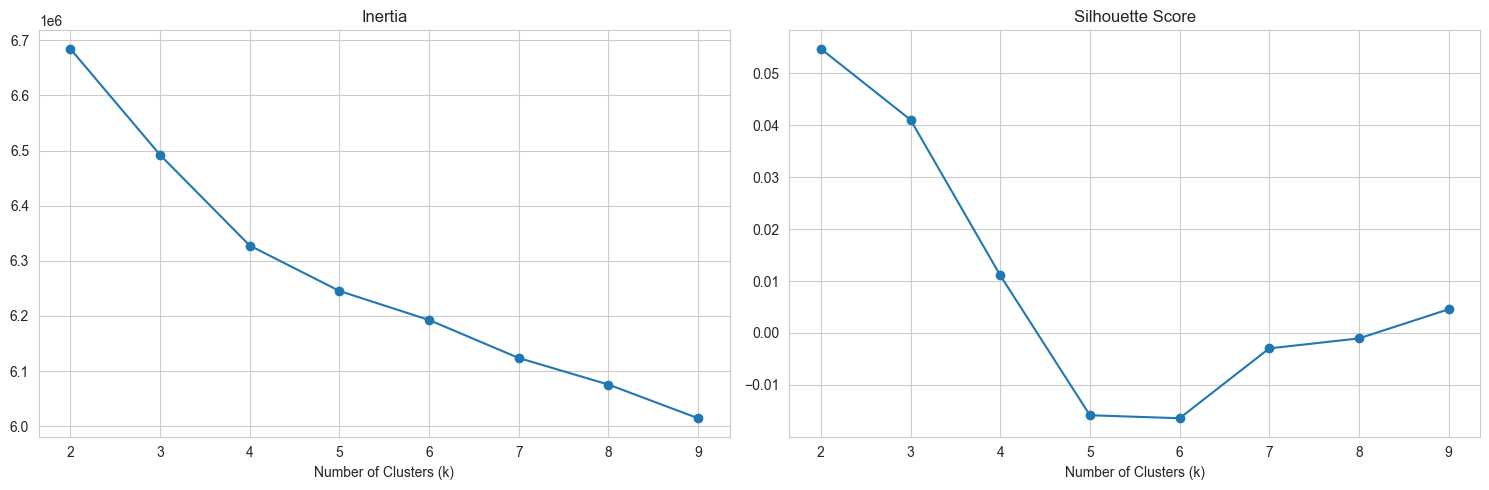

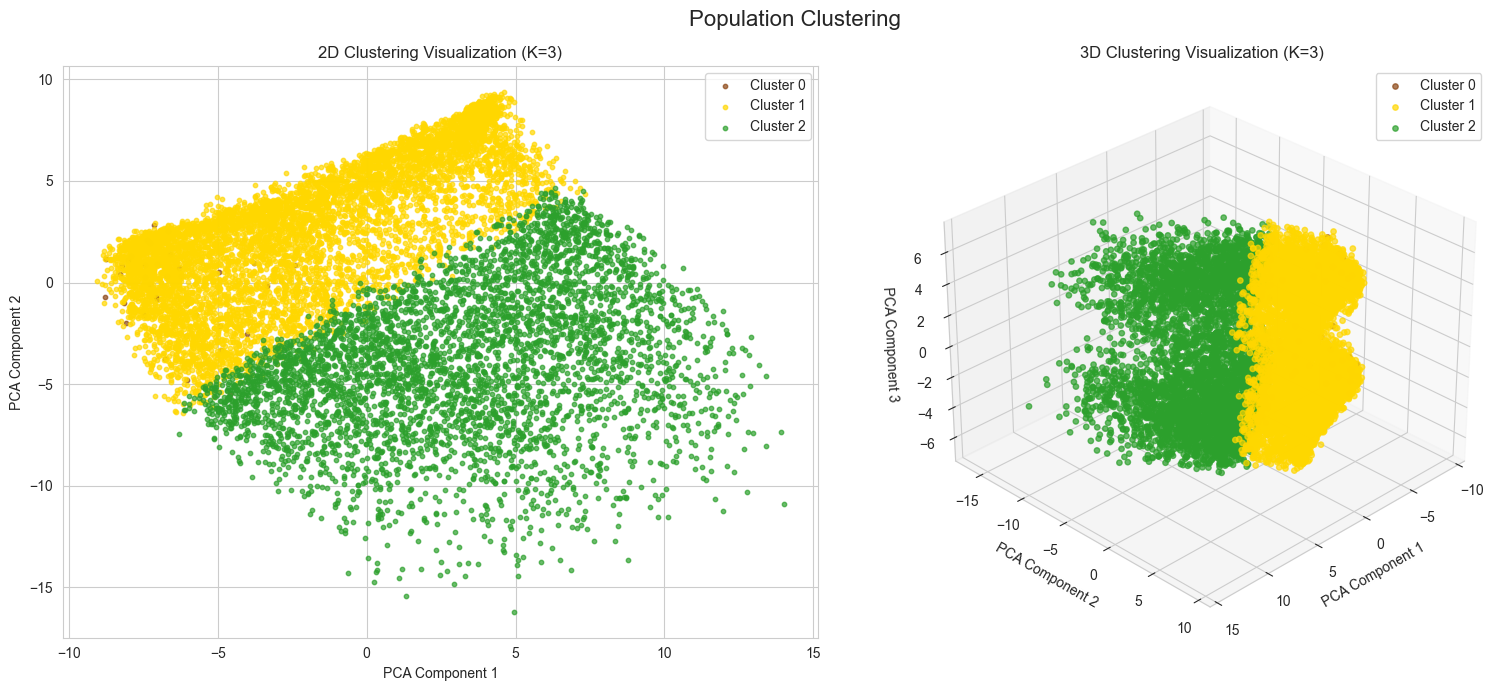


Explained variance by PCA components (3D):
Component 1: 0.0402 (4.02%)
Component 2: 0.0380 (3.80%)
Component 3: 0.0220 (2.20%)
Total explained variance (3D): 0.1001 (10.01%)


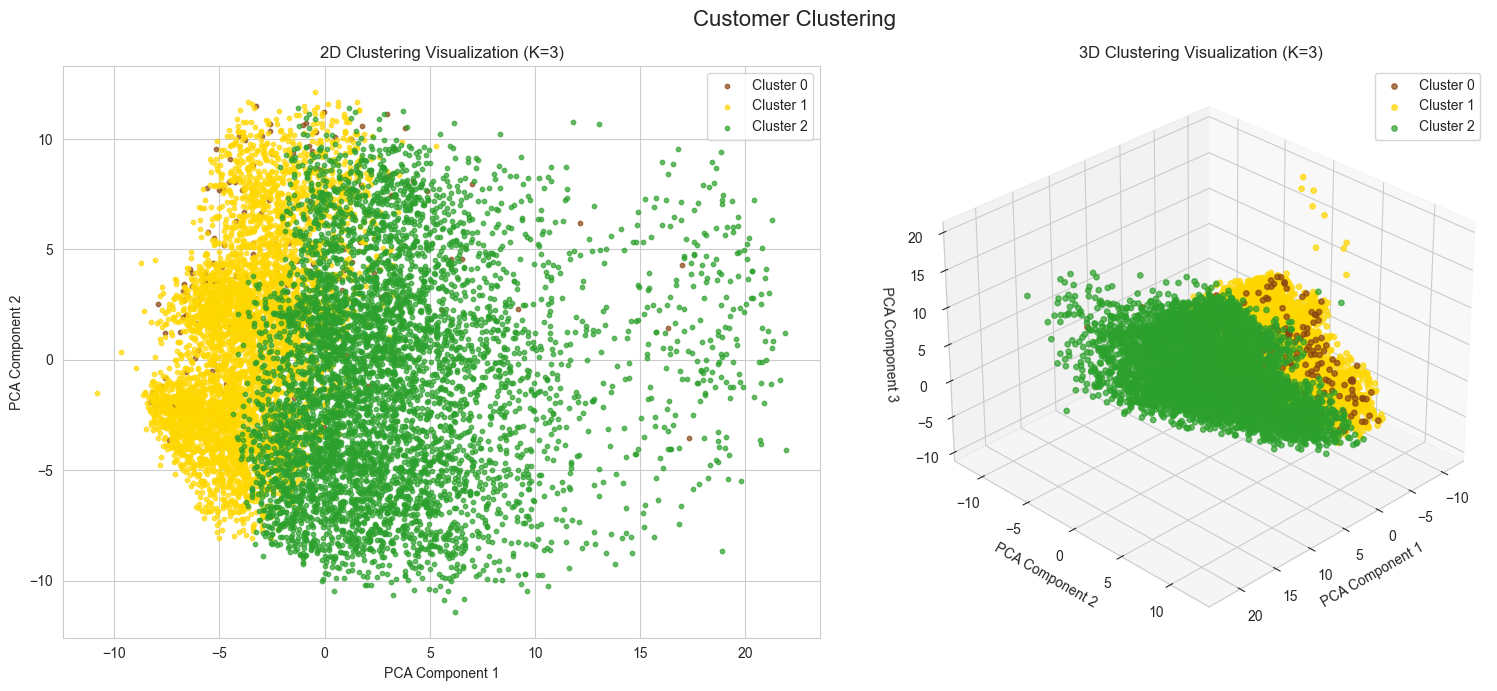


Explained variance by PCA components (3D):
Component 1: 0.0400 (4.00%)
Component 2: 0.0344 (3.44%)
Component 3: 0.0219 (2.19%)
Total explained variance (3D): 0.0963 (9.63%)


In [1016]:
# scale population and customer data using the same scaler.
scaler = StandardScaler()

# Fit the scaler on the population data only
scaler.fit(azdias_data_transformed)

# Transform both datasets using the same fitted scaler
azdias_scaled = scaler.transform(azdias_data_transformed)
customers_data_scaled = scaler.transform(customers_data_transformed)


cluster_analysis_range = range(2, 10)
results = evaluate_kmeans_clustering(azdias_scaled, 
                                     cluster_range=cluster_analysis_range)

plot_kmeans_metrics(cluster_analysis_range, 
                    results['inertia_scores'], 
                    results['silhouette_scores'])


optimal_k = 3  # Example value based on elbow analysis
population_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
population_kmeans.fit(azdias_scaled)


population_cluster_labels = population_kmeans.labels_
plot_clusters(azdias_scaled, 
              population_cluster_labels, 
              optimal_k, 
              plot_title="Population Clustering")


customer_cluster_labels = population_kmeans.predict(customers_data_scaled)
plot_clusters(customers_data_scaled, 
              customer_cluster_labels, 
              optimal_k, 
              plot_title="Customer Clustering")





### Findings

In [1054]:
def analyze_dummy_categorical_features(data, cluster_labels, 
                                       categorical_prefixes, 
                                       cluster_num):
    """
    Analyze dummy-encoded categorical features in a cluster
    """
    results = {}
    
    for prefix in categorical_prefixes:
        # Find all columns with this prefix
        dummy_cols = [col for col in data.columns if col.startswith(prefix)]
        
        if not dummy_cols:
            print(f"No columns found with prefix '{prefix}'")
            continue
            
        # Calculate mean value (proportion) for each dummy in this cluster
        cluster_data = data[cluster_labels == cluster_num]
        other_data = data[cluster_labels != cluster_num]
        
        cluster_means = (cluster_data[dummy_cols].mean()
                         .sort_values(ascending=False))
        
        other_means = (other_data[dummy_cols].mean()
                       .sort_values(ascending=False))
        
        # Combine into a DataFrame
        comparison = pd.DataFrame({
            f'Cluster {cluster_num}': cluster_means,
            'Other Clusters': other_means
        })
        
        # Calculate the difference
        comparison['Difference'] = (
            comparison[f'Cluster {cluster_num}'] - comparison['Other Clusters']
        )
        comparison = comparison.sort_values('Difference', ascending=False)
        
        results[prefix] = comparison
    
    return results

# Create category-specific translation dictionaries
translations = {
    'alterskategorie_grob': {
        '1.0': 'Under 30',
        '2.0': '30-45 years',
        '3.0': '46-60 years',
        '4.0': 'Over 60'
    },
    'anrede_kz': {
        '1': 'Male',
        '2': 'Female'
    },
    'finanztyp': {
    '1': 'Low Financial Engagement',
    '2': 'Saver',
    '3': 'Homeownership-Oriented',
    '4': 'Financially Cautious',
    '5': 'Investor',
    '6': 'Average Financial Behavior'
    },
    'lp_familie_fein': {
    '0.0': 'Unknown',
    '1.0': 'Single',
    '2.0': 'Couple',
    '3.0': 'Young single parent',
    '4.0': 'Single parent with teenager',
    '5.0': 'Single parent with child of full age',
    '6.0': 'Young family',
    '7.0': 'Family with teenager',
    '8.0': 'Family with child of full age',
    '9.0': 'Shared flat',
    '10.0': 'Two-generational household',
    '11.0': 'Multi-generational household'
}
}

def create_cluster_comparison_chart(categorical_results, cluster_num=1):
    # Extract top differences for each category
    viz_data = []
    
    for category, df in categorical_results.items():
        # Get the category name without '_dummy'
        category_name = category.replace('_dummy', '')
        
        # Get top 2 features by absolute difference
        top_features = df.sort_values(by='Difference', key=abs, ascending=False).head(2)
        
        for feature, row in top_features.iterrows():
            feature_code = feature.split('_dummy_')[-1]  # Extract just the category value
            
            # Get the translation specific to this category
            category_translations = translations.get(category_name, {})
            translation = category_translations.get(feature_code, 'Unknown')
            
            viz_data.append({
                'Category': category_name,
                'Feature_Code': feature_code,
                'Feature_Label': f"{feature_code} = {translation}",
                f'Cluster {cluster_num}': row[f'Cluster {cluster_num}'],
                'Other Clusters': row['Other Clusters'],
                'Difference': row['Difference']
            })
    
    return pd.DataFrame(viz_data)

# Create improved visualization with inline translation key
def plot_cluster_comparison_translated(viz_df, cluster_num=1):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.flatten()
    
    categories = viz_df['Category'].unique()
    category_labels = {
        'alterskategorie_grob': 'Age Category',
        'anrede_kz': 'Gender',
        'finanztyp': 'Financial Type',
        'lp_familie_fein': 'Family Status'
    }
    
    for i, category in enumerate(categories):
        category_data = viz_df[viz_df['Category'] == category]
        
        # Create grouped bar chart
        x = np.arange(len(category_data))
        width = 0.35
        
        bars1 = axes[i].bar(x - width/2, category_data[f'Cluster {cluster_num}'], width, label=f'Cluster {cluster_num}', color='#1f77b4')
        bars2 = axes[i].bar(x + width/2, category_data['Other Clusters'], width, label='Other Clusters', color='#ff7f0e')
        
        # Add feature labels with translation inline
        axes[i].set_xticks(x)
        axes[i].set_xticklabels(category_data['Feature_Label'], rotation=45, ha='right')
        
        # Add values on bars
        for j, bar in enumerate(bars1):
            height = bar.get_height()
            axes[i].annotate(f'{height:.2f}', 
                           xy=(bar.get_x() + bar.get_width()/2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom')
                           
        for j, bar in enumerate(bars2):
            height = bar.get_height()
            axes[i].annotate(f'{height:.2f}', 
                           xy=(bar.get_x() + bar.get_width()/2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom')
        
        # Add category title with proper label
        axes[i].set_title(category_labels.get(category, category.title().replace('_', ' ')))
        axes[i].set_ylim(0, 1.0)
        axes[i].set_ylabel('Proportion')
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
        axes[i].legend()
    
    plt.tight_layout()
    plt.suptitle(f"Cluster {cluster_num} vs Other Clusters: Key Demographic Differences", fontsize=16, y=1.02)
    plt.subplots_adjust(top=0.94)
    plt.show()

# Create a simplified chart focusing on key differences with inline labels
def plot_key_differences_translated(categorical_results, cluster_num=1):
    # Extract the biggest difference from each category
    differences = []
    
    for category, df in categorical_results.items():
        top_diff = df.iloc[0]  # Get the row with the biggest difference
        feature_code = df.index[0].split('_dummy_')[-1]
        category_name = category.replace('_dummy', '')
        
        # Get translated category name
        category_label = {
            'alterskategorie_grob': 'Age',
            'anrede_kz': 'Gender',
            'finanztyp': 'Finance',
            'lp_familie_fein': 'Family'
        }.get(category_name, category_name)
        
        # Create combined feature label with translation
        # Get the translation specific to this category
        category_translations = translations.get(category_name, {})
            
        feature_label = f"{category_label}: {feature_code} ({category_translations.get(feature_code, 'Unknown')})"
        
        differences.append({
            'Feature': feature_label,
            f'Cluster {cluster_num}': top_diff[f'Cluster {cluster_num}'],
            'Other Clusters': top_diff['Other Clusters'],
            'Difference': top_diff['Difference']
        })
    
    diff_df = pd.DataFrame(differences).sort_values('Difference', ascending=False)
    
    # Create visualization
    plt.figure(figsize=(12, 7))
    
    # Create grouped bar chart
    x = np.arange(len(diff_df))
    width = 0.35
    
    bars1 = plt.bar(x - width/2, diff_df[f'Cluster {cluster_num}'], width, label=f'Cluster {cluster_num}', color='#1f77b4')
    bars2 = plt.bar(x + width/2, diff_df['Other Clusters'], width, label='Other Clusters', color='#ff7f0e')
    
    # Add feature labels (already translated)
    plt.xticks(x, diff_df['Feature'], rotation=45, ha='right')
    
    # Add values on bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        plt.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
                    
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        plt.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
    
    plt.title(f'Key Distinguishing Features of Cluster {cluster_num}', fontsize=15)
    plt.ylabel('Proportion')
    plt.ylim(0, max(diff_df[f'Cluster {cluster_num}'].max(), diff_df['Other Clusters'].max()) * 1.2)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    plt.show()



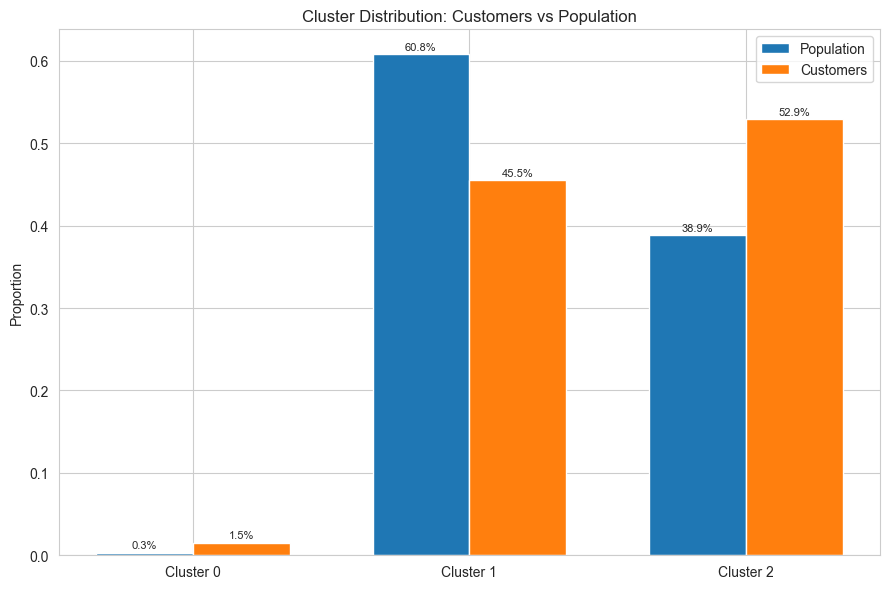

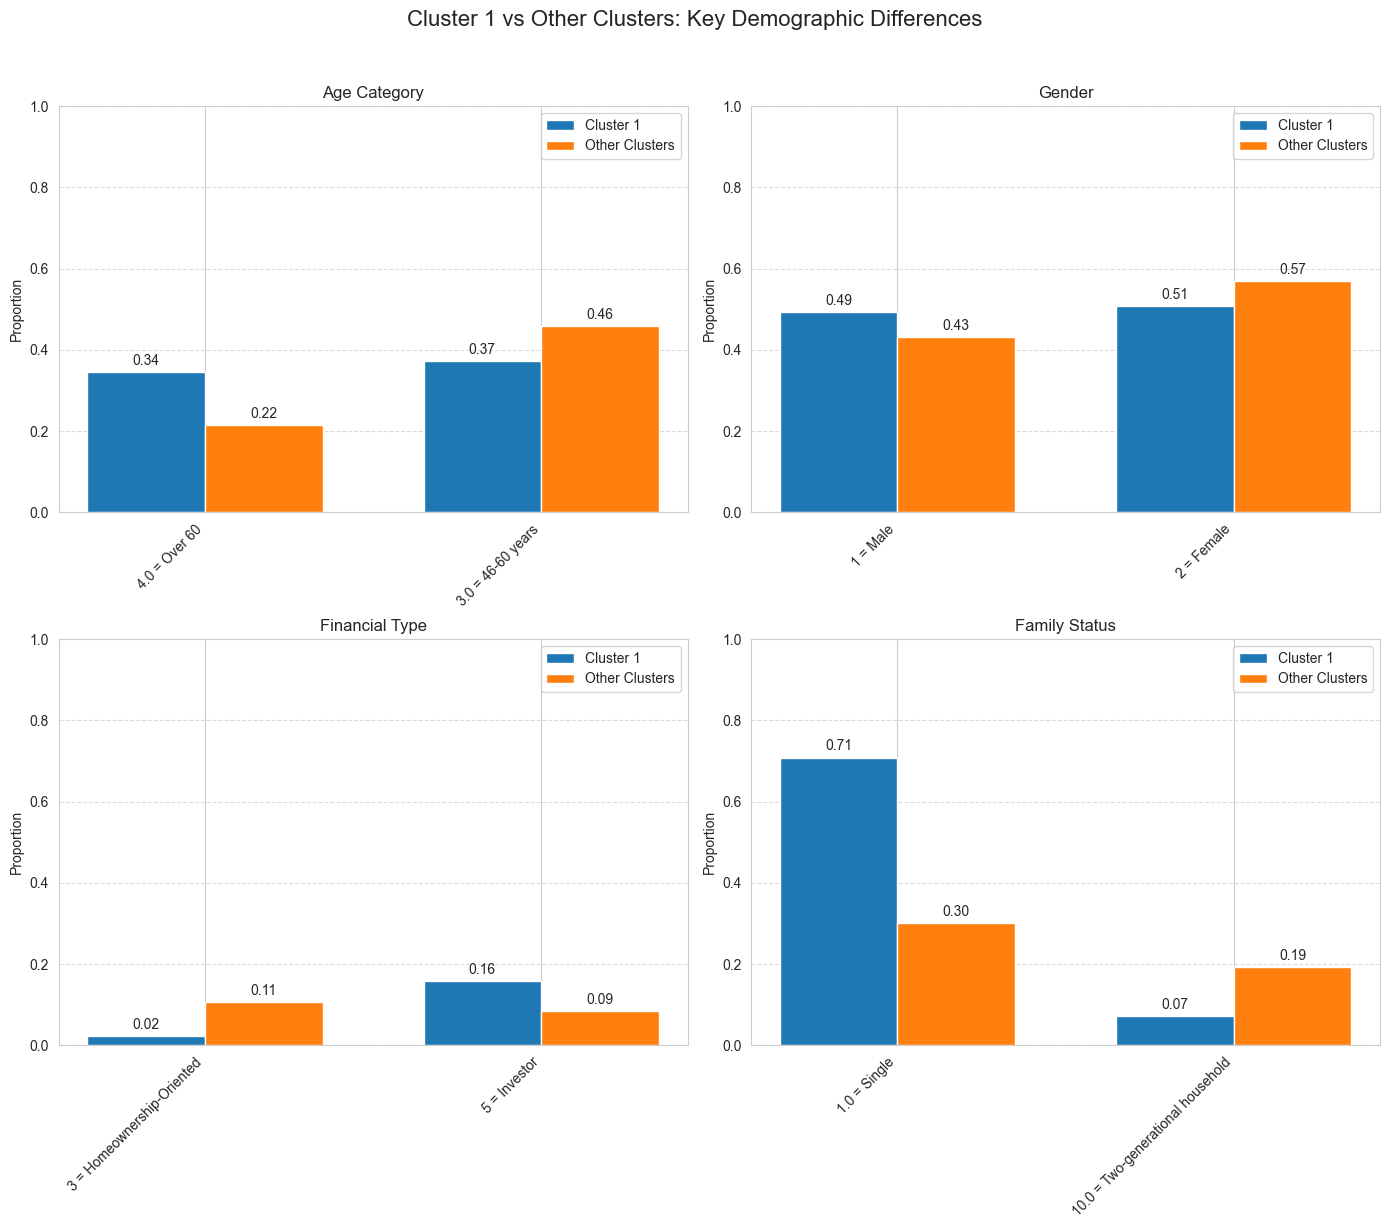

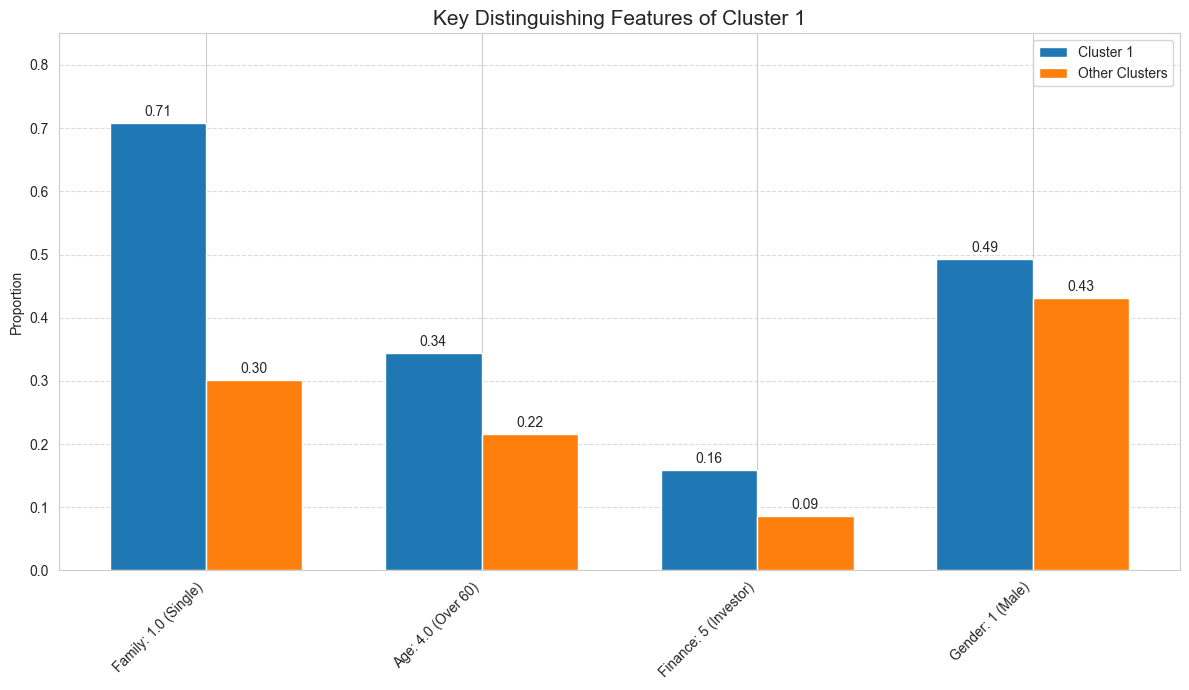

In [1057]:
plot_cluster_distribution(population_kmeans.labels_, customer_cluster_labels)

cluster_num = 1 # cluster we want to focus our analysis on

focus_categories = ['alterskategorie_grob_dummy', 
                    'anrede_kz_dummy', 
                    'finanztyp_dummy',
                    'lp_familie_fein_dummy']

categorical_results = analyze_dummy_categorical_features(
    azdias_data_transformed,
    population_kmeans.labels_,
    focus_categories,
    cluster_num=cluster_num
)

# Execute the visualizations with inline translation as keys
viz_df = create_cluster_comparison_chart(categorical_results, cluster_num)
plot_cluster_comparison_translated(viz_df, cluster_num)
plot_key_differences_translated(categorical_results, cluster_num)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [1019]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
print(mailout_train.shape)

(42962, 367)


/var/folders/dt/drx42mh15fqcyzs6cp88b9dh0000gn/T/ipykernel_74734/2525060866.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


In [1020]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')
print(mailout_test.shape)

(42833, 366)


/var/folders/dt/drx42mh15fqcyzs6cp88b9dh0000gn/T/ipykernel_74734/940582798.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')


In [1021]:
def display_results(y_true, y_pred):
    """
    Display classification results using a confusion matrix visualization.
    
    Parameters
    ----------
    y_true : array-like
        Ground truth (correct) target values.
    y_pred : array-like
        Estimated targets as returned by a classifier.
        
    Returns
    -------
    None
        Displays confusion matrix visualization.
    """

    # Calculate confusion matrix with  labels
    labels = sorted(np.unique(np.concatenate([y_true, y_pred])))
    if len(labels) == 1:  # If only one label is present in both
        if 1 not in labels:
            labels = [0, 1]  # Ensure both classes are represented in matrix
        else:
            labels = [1, 0]
            
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    # Create figure
    plt.figure(figsize=(8, 6))
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    
    # Add class labels
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    
    # Set tick labels
    plt.xticks([0.5, 1.5], ['Negative (0)', 'Positive (1)'])
    plt.yticks([0.5, 1.5], ['Negative (0)', 'Positive (1)'])
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    
    # Set zero_division=0 to handle divide by zero warning
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    metrics_text = f'Metrics:\nAccuracy: {accuracy:.4f}\n' \
                f'Precision: {precision:.4f}\n' \
                f'Recall: {recall:.4f}\nF1-Score: {f1:.4f}'      
                             
    # Add metrics text box in top right corner
    plt.annotate(metrics_text, xy=(0.98, 0.98), xycoords='axes fraction', 
                 bbox=dict(boxstyle="round,pad=0.3", 
                           fc="white", ec="gray", alpha=0.8),
                 ha='right', va='top', fontsize=10)
    
    # Add percentage annotations inside cells
    total = np.sum(cm)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j+0.5, i+0.7, f'({cm[i,j]/total:.1%})', 
                     ha='center', va='center', fontsize=9, color='black')
    
    plt.tight_layout()
    plt.show()

#### NOTE: MAILOUT TRAIN and MAILOUT TEST DATA were uniformly cleaned in the Data Cleaning step the cleaned copies are used for MODELLING. 

In [1022]:
# Extract the target variable (RESPONSE) from the cleaned MAILOUT_TRAIN dataset
y_train_cleaned_data = mailout_train_cleaned_data['RESPONSE']

# Define the features for the cleaned MAILOUT_TRAIN dataset
X_train_cleaned_data = mailout_train_cleaned_data.drop(columns=['RESPONSE'])

X_test_cleaned_data = mailout_test_cleaned_data

print(f"X train cleaned: {X_train_cleaned_data.shape}")
print(f"X test cleaned: {X_test_cleaned_data.shape}")
print(f"Y train cleaned: {y_train_cleaned_data.shape}")

X train cleaned: (10613, 103)
X test cleaned: (10548, 103)
Y train cleaned: (10613,)


##### Transform X train and X test data while ensuring features and feature labels are consistent with Transformed Population & Customer Data.

In [1023]:


X_train_transformed, transform_info = transform_dataframe(
    X_train_cleaned_data.iloc[:], 
    date_columns=date_cols,
    numerical_columns=numerical_cols,
    categorical_columns=categorical_cols
)
X_test_transformed, transform_info = transform_dataframe(
    X_test_cleaned_data.iloc[:], 
    date_columns=date_cols,
    numerical_columns=numerical_cols,
    categorical_columns=categorical_cols,
)

X_test_transformed = X_test_transformed.reindex(
    columns=X_train_transformed.columns, fill_value=False)

y_train_transformed = y_train_cleaned_data

# Use the columns from a population dataframe as the reference,
# for consistent features
reference_columns = azdias_data_transformed.columns

# Reindex all dataframes to match this column set
azdias_data_transformed = azdias_data_transformed.reindex(
    columns=reference_columns, fill_value=False)

customers_data_transformed = customers_data_transformed.reindex(
    columns=reference_columns, fill_value=False)

X_train_transformed = X_train_transformed.reindex(
    columns=reference_columns, fill_value=False)

X_test_transformed = X_test_transformed.reindex(
    columns=reference_columns, fill_value=False)


# Display data type distribution after reindexing.
dtype_counts = (X_train_transformed.dtypes
                .astype(str)
                .value_counts()
                .to_dict())

print("\n")
print(f"    Data Type Distribution After Transformation:")
print(f"    ================")
for dtype, count in dtype_counts.items():
    print(f"    {dtype}: {count} columns")
    
    
# Display data type distribution after transformation
dtype_counts = (X_test_transformed.dtypes
                .astype(str)
                .value_counts()
                .to_dict())

print("\n")
print(f"    Data Type Distribution After Transformation:")
print(f"    ================")
for dtype, count in dtype_counts.items():
    print(f"    {dtype}: {count} columns")


Transformation Summary:
    General Summary:
    Original dataframe shape: ((10613, 103))
    Transformed dataframe shape: ((10613, 565))
    Column names converted to lowercase: 103
    Column names with whitespace stripped: 0
    Date columns converted: 0
    Categorical columns converted: 57
    Dummy variables created: 519
    Total data type changes: 0


    Data Type Distribution After Transformation:
    bool: 519 columns
    int64: 35 columns
    float64: 11 columns


Transformation Summary:
    General Summary:
    Original dataframe shape: ((10548, 103))
    Transformed dataframe shape: ((10548, 560))
    Column names converted to lowercase: 103
    Column names with whitespace stripped: 0
    Date columns converted: 0
    Categorical columns converted: 57
    Dummy variables created: 514
    Total data type changes: 0


    Data Type Distribution After Transformation:
    bool: 514 columns
    int64: 35 columns
    float64: 11 columns




    Data Type Distribution After Tra

In [1024]:
X_train_transformed_stats = get_dataframe_stats(X_train_transformed)
X_test_transformed_stats = get_dataframe_stats(X_test_transformed)

DataFrame Statistics:
    General Summary:
    Dimensions: 10,613 rows × 578 columns
    Memory usage: 9.19 MB
    Rows with missing values: 0 (0.00%)


    Data Type Distribution:
    bool: 532 columns (92.0%)
    int64: 35 columns (6.1%)
    float64: 11 columns (1.9%)


    Total number of rows: 10,613
    Total number of columns: 578
    Percentage of rows with missing data: 0.00%


DataFrame Statistics:
    General Summary:
    Dimensions: 10,548 rows × 578 columns
    Memory usage: 9.13 MB
    Rows with missing values: 0 (0.00%)


    Data Type Distribution:
    bool: 532 columns (92.0%)
    int64: 35 columns (6.1%)
    float64: 11 columns (1.9%)


    Total number of rows: 10,548
    Total number of columns: 578
    Percentage of rows with missing data: 0.00%




In [1025]:
# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_transformed, 
    y_train_transformed, 
    test_size=0.2, 
    random_state=42
)

# Initialize the model (Random Forest Classifier in this case)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_split, y_train_split)

# Make predictions on the validation set
y_val_pred = model.predict(X_val_split)

# View the shape of the splits
# print(X_train_split.shape, X_val_split.shape)
print("Split Summary")
print("=============")
print(f"X train split: {X_train_split.shape}")
print(f"y train split: {y_train_split.shape}")
print(f"X val split: {X_val_split.shape}")
print(f"y val split: {y_val_split.shape}")


Split Summary
X train split: (8490, 578)
y train split: (8490,)
X val split: (2123, 578)
y val split: (2123,)


In [1026]:
# Evaluate the model
accuracy = accuracy_score(y_val_split, y_val_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_val_split, y_val_pred, zero_division=0))


# Predict the likelihood of becoming a customer for the test data
y_test_pred = model.predict(X_test_transformed)

test_predictions = pd.DataFrame({'ID': X_test_transformed.index, 
                                 'RESPONSE': y_test_pred})
# Save the predictions to a CSV file
test_predictions.to_csv('test_predictions.csv', index=False)


Accuracy: 0.9873
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2096
           1       0.00      0.00      0.00        27

    accuracy                           0.99      2123
   macro avg       0.49      0.50      0.50      2123
weighted avg       0.97      0.99      0.98      2123



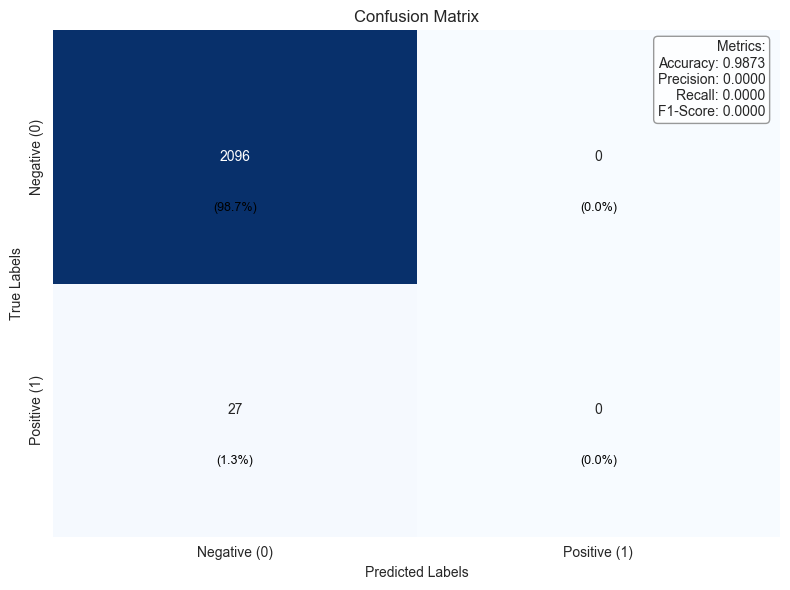

In [1027]:
display_results(y_val_split, y_val_pred)


### Training a Supervised Learning Model with Predicted Cluster Labels as an Additional Feature

To enhance the performance of our supervised learning model, we incorporate insights from unsupervised clustering. Using KMeans clustering on the general population dataset, we predicted cluster labels for both the training and test datasets. These cluster labels, representing underlying groupings within the data, are added as new categorical features.

By one-hot encoding the cluster labels, we allow the model to treat each segment as a distinct indicator variable. This helps the model potentially uncover segment-specific behaviors or patterns that may influence the target prediction.






In [1028]:
# Scale the datasets using the same scaler used in training the clustering -
# - model
X_train_scaled = scaler.transform(X_train_transformed)
X_test_scaled = scaler.transform(X_test_transformed)

# Predict clusters
train_cluster_labels = population_kmeans.predict(X_train_scaled)
test_cluster_labels = population_kmeans.predict(X_test_scaled)

X_train_with_cluster = X_train_transformed.copy()
X_test_with_cluster = X_test_transformed.copy()

X_train_with_cluster['Cluster_Label'] = train_cluster_labels
X_test_with_cluster['Cluster_Label'] = test_cluster_labels

# One-hot encode the cluster label column
X_train_with_cluster = pd.get_dummies(X_train_with_cluster, columns=['Cluster_Label'])
X_test_with_cluster = pd.get_dummies(X_test_with_cluster, columns=['Cluster_Label'])

# Ensure both train and test sets have the same columns
X_test_with_cluster = X_test_with_cluster.reindex(
    columns=X_train_with_cluster.columns, 
    fill_value=False)

# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_with_cluster, y_train_transformed, test_size=0.2, 
    random_state=42)

# View the shape of the splits
# print(X_train_split.shape, X_val_split.shape)
print("Split Summary")
print("=============")
print(f"X train with cluster split: {X_train_split.shape}")
print(f"y train split: {y_train_split.shape}")
print(f"X val with cluster split: {X_val_split.shape}")
print(f"y val split: {y_val_split.shape}")





Split Summary
X train with cluster split: (8490, 581)
y train split: (8490,)
X val with cluster split: (2123, 581)
y val split: (2123,)


### Train Model

In [1047]:
# Initialize the model (Random Forest Classifier in this case)
model = RandomForestClassifier(n_estimators=100, 
                               random_state=42)

# Train the model
model.fit(X_train_split, y_train_split)


print("Fit Summary")
print("=============")
print(f"X_test_with_cluster: {X_test_with_cluster.shape}")
print(f"X_test without cluster: {X_test_transformed.shape}")
# print(f"y pred: {y_test_pred.shape}")

Fit Summary
X_test_with_cluster: (10548, 581)
X_test without cluster: (10548, 578)


### Evaluate Model

In [1048]:
# Make predictions on the validation set
y_val_pred = model.predict(X_val_split)

# Evaluate the model
accuracy = accuracy_score(y_val_split, y_val_pred)
print(f'Model Accuracy: {accuracy:.4f}')
print(classification_report(y_val_split, y_val_pred, zero_division=0))

Model Accuracy: 0.9873
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2096
           1       0.00      0.00      0.00        27

    accuracy                           0.99      2123
   macro avg       0.49      0.50      0.50      2123
weighted avg       0.97      0.99      0.98      2123



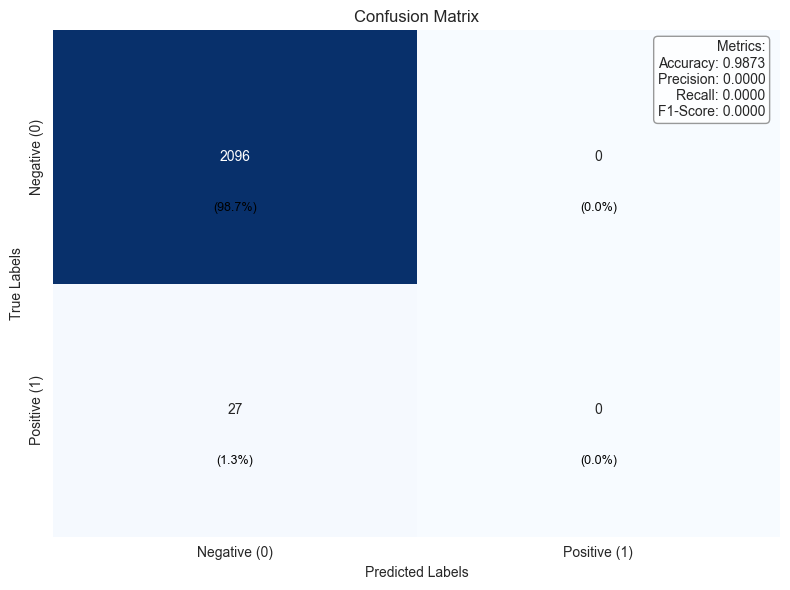

In [1049]:
display_results(y_val_split, y_val_pred)

### Predict the likelihood of becoming a customer for the test data


In [1032]:
# Predict the likelihood of becoming a customer for the test data
y_test_pred = model.predict(X_test_with_cluster)

# Save predicted labels to CSV file.
test_predictions = pd.DataFrame({'ID': X_test_with_cluster.index, 'RESPONSE': y_test_pred})
test_predictions.to_csv('test_predictions.csv', index=False)


### Model Hyper-parameter Finetuning

In [ ]:
# Set up parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train_split, y_train_split)

# View the best parameters and the best score
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best Score: {grid_search.best_score_}')

Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.9859835100117786


#### Best parameters from GridSearchCV

Model Accuracy: 0.9873


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2096
           1       0.00      0.00      0.00        27

    accuracy                           0.99      2123
   macro avg       0.49      0.50      0.50      2123
weighted avg       0.97      0.99      0.98      2123



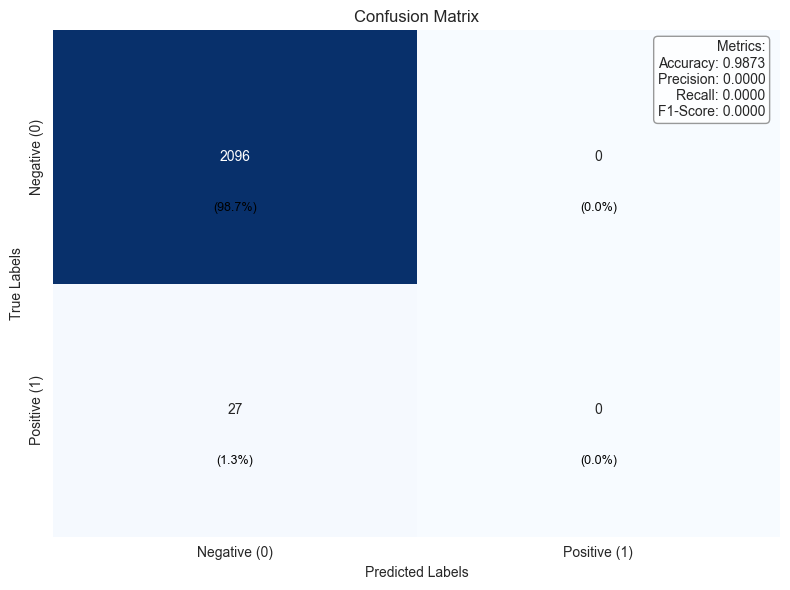

In [ ]:
# using the best model from GridSearchCV
best_model = grid_search.best_estimator_
best_model.fit(X_train_split, y_train_split)


# Make predictions on the validation set
y_val_pred = best_model.predict(X_val_split)

# Evaluate the model
accuracy = accuracy_score(y_val_split, y_val_pred)
print(f'Model Accuracy: {accuracy:.4f}')
print("\n")
print(classification_report(y_val_split, y_val_pred, zero_division=0))

display_results(y_val_split, y_val_pred)

### GLOSSARY


- eingefuegt_am - inserted date
- eingezogenam_hh_jahr - Year moved into the household

### CONCLUSION

- Insights about Arvato Bertel'smann's Customer Demographic.
- Balancing of Train Data

In [1061]:
mailout_train_cleaned_data["RESPONSE"].value_counts()

RESPONSE
0    10467
1      146
Name: count, dtype: int64

In [1062]:
(146/10467) * 100

1.3948600363045762